In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame

import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Read in the data
* Data from five US states were collected for study.

In [2]:
path='data/'

file_2020q1_OH=pd.read_csv(path+'file_2020Q1_OH.csv')
file_2020q1_VA=pd.read_csv(path+'file_2020Q1_VA.csv')
file_2020q1_GA=pd.read_csv(path+'file_2020Q1_GA.csv')
file_2020q1_MI=pd.read_csv(path+'file_2020Q1_MI.csv')
file_2020q1_CO=pd.read_csv(path+'file_2020Q1_CO.csv')

In [3]:
df=pd.concat([file_2020q1_OH, file_2020q1_VA, file_2020q1_GA, file_2020q1_MI, file_2020q1_CO])
df.shape

(2071611, 108)

In [4]:
df.head()

POOL_ID   LOAN_ID  ACT_PERIOD CHANNEL SELLER SERVICER  MASTER_SERVICER  \
0      NaN  98836743       12020       R  Other    Other              NaN   
1      NaN  98836743       22020       R  Other    Other              NaN   
2      NaN  98836743       32020       R  Other    Other              NaN   
3      NaN  98836743       42020       R  Other    Other              NaN   
4      NaN  98836743       52020       R  Other    Other              NaN   

   ORIG_RATE  CURR_RATE  ORIG_UPB  ...  MARGIN  BALLOON_INDICATOR  \
0      3.625      3.625  207000.0  ...     NaN                NaN   
1      3.625      3.625  207000.0  ...     NaN                NaN   
2      3.625      3.625  207000.0  ...     NaN                NaN   
3      3.625      3.625  207000.0  ...     NaN                NaN   
4      3.625      3.625  207000.0  ...     NaN                NaN   

   PLAN_NUMBER  FORBEARANCE_INDICATOR  \
0          NaN                      7   
1          NaN                      7   
2          NaN                      7   
3          NaN                      7   
4          NaN                      7   

   HIGH_LOAN_TO_VALUE_HLTV_REFINANCE_OPTION_INDICATOR  DEAL_NAME  \
0                                                  N         NaN   
1                                                  N         NaN   
2                                                  N         NaN   
3                                                  N         NaN   
4                                                  N         NaN   

   RE_PROCS_FLAG  ADR_TYPE  ADR_COUNT  ADR_UPB  
0            NaN         7        NaN      NaN  
1            NaN         7        NaN      NaN  
2            NaN         7        NaN      NaN  
3            NaN         7        NaN      NaN  
4            NaN         7        NaN      NaN  

[5 rows x 108 columns]

In [5]:
df['LOAN_ID'].nunique()

104924

In [6]:
df.groupby('STATE')['LOAN_ID'].count()

STATE
CO    485045
GA    428255
MI    479014
OH    339552
VA    339745
Name: LOAN_ID, dtype: int64

In [7]:
df.groupby('STATE')['LOAN_ID'].nunique()

STATE
CO    27121
GA    20888
MI    23998
OH    15667
VA    17250
Name: LOAN_ID, dtype: int64

* There are more than 2,000,000 data points, about 105,000 unique 'LOAN_ID'. 

# Step 2: Define 'bad'

* The purpose of developing a Mortgage Default Model is to classify loans as either 'good' or 'bad.' 
* A new column labeled 'bad' will be added, where a value of '1' indicates a 'bad' loan (i.e., defaulted) and '0' indicates a 'good' loan (i.e., not defaulted).

In [8]:
df.columns.tolist()

['POOL_ID',
 'LOAN_ID',
 'ACT_PERIOD',
 'CHANNEL',
 'SELLER',
 'SERVICER',
 'MASTER_SERVICER',
 'ORIG_RATE',
 'CURR_RATE',
 'ORIG_UPB',
 'ISSUANCE_UPB',
 'CURRENT_UPB',
 'ORIG_TERM',
 'ORIG_DATE',
 'FIRST_PAY',
 'LOAN_AGE',
 'REM_MONTHS',
 'ADJ_REM_MONTHS',
 'MATR_DT',
 'OLTV',
 'OCLTV',
 'NUM_BO',
 'DTI',
 'CSCORE_B',
 'CSCORE_C',
 'FIRST_FLAG',
 'PURPOSE',
 'PROP',
 'NO_UNITS',
 'OCC_STAT',
 'STATE',
 'MSA',
 'ZIP',
 'MI_PCT',
 'PRODUCT',
 'PPMT_FLG',
 'IO',
 'FIRST_PAY_IO',
 'MNTHS_TO_AMTZ_IO',
 'DLQ_STATUS',
 'PMT_HISTORY',
 'MOD_FLAG',
 'MI_CANCEL_FLAG',
 'Zero_Bal_Code',
 'ZB_DTE',
 'LAST_UPB',
 'RPRCH_DTE',
 'CURR_SCHD_PRNCPL',
 'TOT_SCHD_PRNCPL',
 'UNSCHD_PRNCPL_CURR',
 'LAST_PAID_INSTALLMENT_DATE',
 'FORECLOSURE_DATE',
 'DISPOSITION_DATE',
 'FORECLOSURE_COSTS',
 'PROPERTY_PRESERVATION_AND_REPAIR_COSTS',
 'ASSET_RECOVERY_COSTS',
 'MISCELLANEOUS_HOLDING_EXPENSES_AND_CREDITS',
 'ASSOCIATED_TAXES_FOR_HOLDING_PROPERTY',
 'NET_SALES_PROCEEDS',
 'CREDIT_ENHANCEMENT_PROCEEDS',
 'REPUR

* The column 'DLQ_Status' (Delinquency Status) indicates the number of months the client has failed to make their monthly loan payments. 
* The values range from 0 to 24, where 0 means the loan is current and higher numbers represent increasing months of delinquency.

In [9]:
df.groupby('DLQ_STATUS')['LOAN_ID'].count()

DLQ_STATUS
0     2019379
1       14783
2        7204
3        5353
4        3983
5        3351
6        2724
7        2209
8        1934
9        1704
10       1510
11       1368
12       1146
13        963
14        856
15        746
16        617
17        557
18        409
19        296
20        250
21        145
22         70
23         40
24         14
Name: LOAN_ID, dtype: int64

* A threshold of 6 is used to define 'bad' loans. 
* DLQ_Status values less than 6 are defined as 'good', while values equal to or greater than 6 are defined as 'bad'.

In [10]:
df['bad']=np.where(df['DLQ_STATUS'] >= 6, 1, 0)
df_bad=df.groupby('LOAN_ID')['bad'].sum().reset_index()
df_bad['bad']=np.where(df_bad['bad'] > 0, 1, 0)

In [11]:
df_bad.head

<bound method NDFrame.head of          LOAN_ID  bad
0       98836742    0
1       98836743    0
2       98836744    0
3       98836781    0
4       98836789    0
...          ...  ...
104919  99520417    0
104920  99520428    0
104921  99520430    0
104922  99520446    1
104923  99520476    0

[104924 rows x 2 columns]>

In [12]:
print(df_bad['bad'].mean())
print(df_bad['bad'].sum())

0.02353131790629408
2469


* Out of 104,924 loan accounts, there are 2,469 'bad' loans, which represent 2.35% of the total.

# Step 3: Define prepayment
* When a loan is completely paid off before reaching its full maturity, a prepayment occurs. There are several types of prepayment:

    * Voluntary prepayment: The borrower chooses to pay off the loan early, either by making extra payments or paying the full outstanding balance. This can happen when the borrower has extra funds or refinances the loan at better terms. In such cases, the old loan is removed from the books.

    * Involuntary prepayment: This occurs when a loan is paid off early due to external events such as foreclosure, charge-off, or the sale of the property by the lender after a default. These types of prepayments should be excluded in this case.

* Asset holders (usually banks) prefer loans with low default rates and low prepayment rates.

In [13]:
df.groupby('Zero_Bal_Code')['LOAN_ID'].count()

Zero_Bal_Code
1.0     54061
2.0         3
6.0        98
9.0         4
16.0        5
Name: LOAN_ID, dtype: int64

In [14]:
df['prepaid']=np.where(df['Zero_Bal_Code'] > 0, 1, 0)
df_prepaid=df.groupby('LOAN_ID')['prepaid'].sum().reset_index()
df_prepaid['prepaid']=np.where(df_prepaid['prepaid'] > 0, 1, 0)

* The 'prepaid' column is created to indicate whether the loan has been prepaid or is current. 
* Zero_Bal_Code indicates if the loan has been prepaid: 
    * Values greater than 1 mean the loan is prepaid
    * Values less than 1 or missing indicate the loan is current.

### Combine payment default and prepayment data

* Involuntary prepayments are marked as both 'bad' and 'prepaid' because the balance was written off.
* These cases need to be identified, and the 'prepaid' label should be changed to '0' to exclude them from voluntary prepayments

In [15]:
df_bad_prepaid=pd.merge(df_bad, df_prepaid, on='LOAN_ID', how='inner')
df_bad_prepaid['prepaid']=np.where((df_bad_prepaid['bad']==1) & (df_bad_prepaid['prepaid']==1), 0, df_bad_prepaid['prepaid'])

In [16]:
df_bad_prepaid[['bad', 'prepaid']].mean()

bad        0.023531
prepaid    0.509645
dtype: float64

* About 2.35% of the loans are classified as bad, representing an unbalanced sample.
* About 51% of the loans are voluntarily prepaid, which can be considered a balanced sample.

In [17]:
df_bad_prepaid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104924 entries, 0 to 104923
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   LOAN_ID  104924 non-null  int64
 1   bad      104924 non-null  int32
 2   prepaid  104924 non-null  int32
dtypes: int32(2), int64(1)
memory usage: 2.4 MB


# Step 4: Convert character/text/categorical variables to dummy variables

Select relevant features for further analysis.

In [18]:
df.columns.tolist()

['POOL_ID',
 'LOAN_ID',
 'ACT_PERIOD',
 'CHANNEL',
 'SELLER',
 'SERVICER',
 'MASTER_SERVICER',
 'ORIG_RATE',
 'CURR_RATE',
 'ORIG_UPB',
 'ISSUANCE_UPB',
 'CURRENT_UPB',
 'ORIG_TERM',
 'ORIG_DATE',
 'FIRST_PAY',
 'LOAN_AGE',
 'REM_MONTHS',
 'ADJ_REM_MONTHS',
 'MATR_DT',
 'OLTV',
 'OCLTV',
 'NUM_BO',
 'DTI',
 'CSCORE_B',
 'CSCORE_C',
 'FIRST_FLAG',
 'PURPOSE',
 'PROP',
 'NO_UNITS',
 'OCC_STAT',
 'STATE',
 'MSA',
 'ZIP',
 'MI_PCT',
 'PRODUCT',
 'PPMT_FLG',
 'IO',
 'FIRST_PAY_IO',
 'MNTHS_TO_AMTZ_IO',
 'DLQ_STATUS',
 'PMT_HISTORY',
 'MOD_FLAG',
 'MI_CANCEL_FLAG',
 'Zero_Bal_Code',
 'ZB_DTE',
 'LAST_UPB',
 'RPRCH_DTE',
 'CURR_SCHD_PRNCPL',
 'TOT_SCHD_PRNCPL',
 'UNSCHD_PRNCPL_CURR',
 'LAST_PAID_INSTALLMENT_DATE',
 'FORECLOSURE_DATE',
 'DISPOSITION_DATE',
 'FORECLOSURE_COSTS',
 'PROPERTY_PRESERVATION_AND_REPAIR_COSTS',
 'ASSET_RECOVERY_COSTS',
 'MISCELLANEOUS_HOLDING_EXPENSES_AND_CREDITS',
 'ASSOCIATED_TAXES_FOR_HOLDING_PROPERTY',
 'NET_SALES_PROCEEDS',
 'CREDIT_ENHANCEMENT_PROCEEDS',
 'REPUR

In [19]:
columns_to_keep=["ACT_PERIOD", "POOL_ID", "LOAN_ID", "ACT_PERIOD", "CHANNEL", "ORIG_RATE", "CURR_RATE", "ORIG_UPB", "ISSUANCE_UPB",
                 "CURRENT_UPB", "ORIG_TERM", "ORIG_DATE", "OLTV", "OCLTV",
                 "DTI", "CSCORE_B", "CSCORE_C", "PURPOSE",
                 "PROP", "NO_UNITS", "STATE", "MSA", "ZIP", "MI_PCT", "DLQ_STATUS", "ORIGINAL_LIST_PRICE",
                 "CURRENT_LIST_PRICE"]

In [20]:
df_nodup=df.drop_duplicates(subset='LOAN_ID', keep='first').reset_index()

In [21]:
df_nodup.groupby('PURPOSE')['LOAN_ID'].count()

PURPOSE
C    26651
P    37427
R    40846
Name: LOAN_ID, dtype: int64

Purpose of loans:
* C (Cash-out Refinance)
* P (Purchase)
* R (Rate/Term Refinance)

In [22]:
# Create dummy variables for 'purpose'
df_nodup['purpose_rate_refi']=np.where(df_nodup['PURPOSE'].str.strip()=='R', 1, 0)
df_nodup['purpose_cashout_refi']=np.where(df_nodup['PURPOSE'].str.strip()=='C', 1, 0)

In [23]:
df.groupby('PROP')['LOAN_ID'].count()

PROP
CO     216617
CP        550
MH      15317
PU     606558
SF    1232569
Name: LOAN_ID, dtype: int64

Type of Property:
* CO: Condominium
* CP: Cooperative Housing (Co-op)
* MH: Manufactured Housing
* PU: Planned Unit Development (PUD)
* SF: Single-Family Residence

In [24]:
# Create dummy variables for 'property'
df_nodup['property_pud']=np.where(df_nodup['PROP'].str.strip()=='PU', 1, 0)
df_nodup['property_condo']=np.where(df_nodup['PROP'].str.strip()=='CO', 1, 0)
df_nodup['property_other']=np.where(df_nodup['PROP'].str.strip().isin(['CP', 'MH']), 1, 0)

In [25]:
df_nodup.groupby('ORIG_TERM')['LOAN_ID'].count()

ORIG_TERM
96        71
108       18
120     1609
121        1
132       24
       ...  
356        1
357        1
358        1
359        1
360    77853
Name: LOAN_ID, Length: 101, dtype: int64

In [26]:
# Create dummy variables for 'term'
df_nodup['term_30years']=np.where(df_nodup['ORIG_TERM']==360, 1, 0)
df_nodup['term_15years']=np.where(df_nodup['ORIG_TERM']==180, 1, 0)

* Columns 'term_30years' and 'term_15years' are created because they may have a strong impact and will be analyzed at the end.

In [27]:
df_nodup['mi']=np.where(df_nodup['MI_PCT'] > 0, 1, 0)

* The 'mi' column is created to indicate whether Mortgage Insurance was purchased, as it may have a strong impact on the target variable.

In [28]:
df_nodup.groupby('PRODUCT')['LOAN_ID'].count()

PRODUCT
FRM    104924
Name: LOAN_ID, dtype: int64

* Column 'PRODUCT' doesn't show variety.

In [29]:
df_nodup.columns.tolist()

['index',
 'POOL_ID',
 'LOAN_ID',
 'ACT_PERIOD',
 'CHANNEL',
 'SELLER',
 'SERVICER',
 'MASTER_SERVICER',
 'ORIG_RATE',
 'CURR_RATE',
 'ORIG_UPB',
 'ISSUANCE_UPB',
 'CURRENT_UPB',
 'ORIG_TERM',
 'ORIG_DATE',
 'FIRST_PAY',
 'LOAN_AGE',
 'REM_MONTHS',
 'ADJ_REM_MONTHS',
 'MATR_DT',
 'OLTV',
 'OCLTV',
 'NUM_BO',
 'DTI',
 'CSCORE_B',
 'CSCORE_C',
 'FIRST_FLAG',
 'PURPOSE',
 'PROP',
 'NO_UNITS',
 'OCC_STAT',
 'STATE',
 'MSA',
 'ZIP',
 'MI_PCT',
 'PRODUCT',
 'PPMT_FLG',
 'IO',
 'FIRST_PAY_IO',
 'MNTHS_TO_AMTZ_IO',
 'DLQ_STATUS',
 'PMT_HISTORY',
 'MOD_FLAG',
 'MI_CANCEL_FLAG',
 'Zero_Bal_Code',
 'ZB_DTE',
 'LAST_UPB',
 'RPRCH_DTE',
 'CURR_SCHD_PRNCPL',
 'TOT_SCHD_PRNCPL',
 'UNSCHD_PRNCPL_CURR',
 'LAST_PAID_INSTALLMENT_DATE',
 'FORECLOSURE_DATE',
 'DISPOSITION_DATE',
 'FORECLOSURE_COSTS',
 'PROPERTY_PRESERVATION_AND_REPAIR_COSTS',
 'ASSET_RECOVERY_COSTS',
 'MISCELLANEOUS_HOLDING_EXPENSES_AND_CREDITS',
 'ASSOCIATED_TAXES_FOR_HOLDING_PROPERTY',
 'NET_SALES_PROCEEDS',
 'CREDIT_ENHANCEMENT_PROCEEDS

In [30]:
columns_to_keep=['LOAN_ID', 'PURPOSE', 'purpose_rate_refi', 'purpose_cashout_refi', 'property_pud', 'property_condo', 'property_other', 
                'term_30years', 'term_15years', 'mi', 'CSCORE_B', 'DTI', 'OLTV', 'ORIG_UPB']

In [31]:
df_select=pd.merge(df_nodup[columns_to_keep], df_bad_prepaid, on='LOAN_ID', how='inner')

In [32]:
df_select.describe().T

count          mean            std         min  \
LOAN_ID               104924.0  9.917922e+07  197019.945107  98836742.0   
purpose_rate_refi     104924.0  3.892913e-01       0.487592         0.0   
purpose_cashout_refi  104924.0  2.540029e-01       0.435301         0.0   
property_pud          104924.0  3.136461e-01       0.463977         0.0   
property_condo        104924.0  1.024360e-01       0.303222         0.0   
property_other        104924.0  6.376044e-03       0.079596         0.0   
term_30years          104924.0  7.419942e-01       0.437539         0.0   
term_15years          104924.0  1.481930e-01       0.355293         0.0   
mi                    104924.0  2.826999e-01       0.450314         0.0   
CSCORE_B              104873.0  7.567624e+02      42.412137       620.0   
DTI                   104922.0  3.415779e+01       9.579630         1.0   
OLTV                  104924.0  7.392929e+01      16.254267         7.0   
ORIG_UPB              104924.0  2.537213e+05  123826.341576     10000.0   
bad                   104924.0  2.353132e-02       0.151584         0.0   
prepaid               104924.0  5.096451e-01       0.499909         0.0   

                              25%         50%          75%         max  
LOAN_ID               99009455.75  99180553.5  99349026.75  99520476.0  
purpose_rate_refi            0.00         0.0         1.00         1.0  
purpose_cashout_refi         0.00         0.0         1.00         1.0  
property_pud                 0.00         0.0         1.00         1.0  
property_condo               0.00         0.0         0.00         1.0  
property_other               0.00         0.0         0.00         1.0  
term_30years                 0.00         1.0         1.00         1.0  
term_15years                 0.00         0.0         0.00         1.0  
mi                           0.00         0.0         1.00         1.0  
CSCORE_B                   729.00       766.0       791.00       835.0  
DTI                         27.00        35.0        42.00        50.0  
OLTV                        65.00        76.0        85.00        97.0  
ORIG_UPB                156000.00    237000.0    335000.00    800000.0  
bad                          0.00         0.0         0.00         1.0  
prepaid                      0.00         1.0         1.00         1.0

# Step 5: Generate additional features

In [33]:
# Create 'home_value' and 'home_value_log' as additional feature
df_select['home_value']=df_select['ORIG_UPB']/df_select['OLTV']
df_select['home_value_log']=np.log(df_select['home_value'])

In [34]:
df_select.describe().T

count          mean            std           min  \
LOAN_ID               104924.0  9.917922e+07  197019.945107  9.883674e+07   
purpose_rate_refi     104924.0  3.892913e-01       0.487592  0.000000e+00   
purpose_cashout_refi  104924.0  2.540029e-01       0.435301  0.000000e+00   
property_pud          104924.0  3.136461e-01       0.463977  0.000000e+00   
property_condo        104924.0  1.024360e-01       0.303222  0.000000e+00   
property_other        104924.0  6.376044e-03       0.079596  0.000000e+00   
term_30years          104924.0  7.419942e-01       0.437539  0.000000e+00   
term_15years          104924.0  1.481930e-01       0.355293  0.000000e+00   
mi                    104924.0  2.826999e-01       0.450314  0.000000e+00   
CSCORE_B              104873.0  7.567624e+02      42.412137  6.200000e+02   
DTI                   104922.0  3.415779e+01       9.579630  1.000000e+00   
OLTV                  104924.0  7.392929e+01      16.254267  7.000000e+00   
ORIG_UPB              104924.0  2.537213e+05  123826.341576  1.000000e+04   
bad                   104924.0  2.353132e-02       0.151584  0.000000e+00   
prepaid               104924.0  5.096451e-01       0.499909  0.000000e+00   
home_value            104924.0  3.551452e+03    1860.135505  1.250000e+02   
home_value_log        104924.0  8.038899e+00       0.541850  4.828314e+00   

                               25%           50%           75%           max  
LOAN_ID               9.900946e+07  9.918055e+07  9.934903e+07  9.952048e+07  
purpose_rate_refi     0.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00  
purpose_cashout_refi  0.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00  
property_pud          0.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00  
property_condo        0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
property_other        0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
term_30years          0.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  
term_15years          0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
mi                    0.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00  
CSCORE_B              7.290000e+02  7.660000e+02  7.910000e+02  8.350000e+02  
DTI                   2.700000e+01  3.500000e+01  4.200000e+01  5.000000e+01  
OLTV                  6.500000e+01  7.600000e+01  8.500000e+01  9.700000e+01  
ORIG_UPB              1.560000e+05  2.370000e+05  3.350000e+05  8.000000e+05  
bad                   0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
prepaid               0.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  
home_value            2.200000e+03  3.257143e+03  4.516854e+03  3.187500e+04  
home_value_log        7.696213e+00  8.088606e+00  8.415571e+00  1.036958e+01

* There are missing values in column 'CSCORE_B' and 'DTI'

In [35]:
# Remove rows that have missing values
df_select=df_select[(df_select['CSCORE_B'] > 0) & (df_select['DTI'] >= 0)]

In [36]:
# create additional features
df_select['DTI_LTV']=df_select['DTI']*df_select['OLTV']*100
df_select['DTI_LTV2']=df_select['DTI']/df_select['OLTV']
df_select['DTI_UPB_log']=df_select['DTI']*df_select['ORIG_UPB']
df_select['DTI_UPB_log2']=df_select['DTI']/df_select['ORIG_UPB']*100

* DTI: Debt-to-Income ratio
* OLTV: Original Loan-to-Value ratio
* ORIG_UPB: Original Unpaid Principal Balance

# Step 6: Split the sample into modeling sample and validation sample

In [37]:
#!pip install xgboost
#!pip install featurewiz
#!pip install imlearn
#!pip install Pillow==9.0.0

In [38]:
# split the sample to modeling sample and validation sample
df_select['random']=np.random.uniform(0, 1, len(df_select['LOAN_ID']))
df_select['seg']=np.where(df_select['random'] <= 0.6, 'mod', 'val')

In [39]:
df_select.groupby('seg')['LOAN_ID'].count()

seg
mod    62810
val    42061
Name: LOAN_ID, dtype: int64

# Step 7: Prepayment Model

In [40]:
!pip install featurewiz
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from featurewiz import featurewiz
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

tensorflow >= 2.5 not installed in machine. Please install and try again. 


NameError: name 'layers' is not defined

* Develop an evaluation function and output AUC-ROC as the weight for ensemble method later.

In [41]:
def model_evaluation():

    #Accuracy score
    print('Accuracy: %.3f' % accuracy_score(y_test, preds))

    #Precision score - model precision score represents the model’s ability to correctly predict the positives out of all the positive predictions it made
    print('Precision: %.3f' % precision_score(y_test, preds)) 

    #Recall score - model recall score represents the model’s ability to correctly predict the positives out of actual positives
    print('Recall: %.3f' % recall_score(y_test, preds))

    #Confusion matrix
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)       

    #ROC & AUC
    #Generate a baseline prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]

    #Predict probabilities
    lr_probs = model.predict_proba(X_test)

    #Keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]

    #Calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)

    #Summarize scores
    print('Baseline: ROC AUC = %.3f' % (ns_auc))
    print(model_name+': ROC AUC = %.3f' % (lr_auc))

    #Calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

    #Plot the roc curve for the model
    plt.figure()
    plt.plot(ns_fpr, ns_tpr, linestyle = '--', label = 'Baseline')
    plt.plot(lr_fpr, lr_tpr, marker = '.', label = model_name)

    #Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title("ROC Curve")
    plt.show()

    #Predicted vs. actual graphs
    actuals_y = pd.DataFrame(data = actuals, columns = [target])
    probs_y = pd.DataFrame(data = probs, columns = ['score1', 'score2'])
    actuals_probs = pd.concat([actuals_y, probs_y], axis = 1)
    num_bins = 20
    binlabels = list(range(0, num_bins))
    actuals_probs['score_bin'] = pd.qcut(actuals_probs['score2'].rank(method = 'first'), num_bins, labels = binlabels)
    actuals_probs['score_bin'] = num_bins - actuals_probs['score_bin'].astype(int)
    df_grp = actuals_probs.groupby('score_bin')['score2'].mean()
    df_grp.plot()
    df_grp2 = actuals_probs.groupby('score_bin')[target].mean()
    df_grp2.plot()
    plt.legend(["Predicted", "Actual"])
    plt.xlabel('Score Bin')
    plt.title("Predicted vs. Actual")
    
    # save AUC ROC and use it as the weight in the ensemble method later
    return(lr_auc)

#### Define the target variable

In [42]:
target='prepaid'

In [43]:
X=['purpose_rate_refi', 'purpose_cashout_refi', 'property_pud', 'property_condo', 'property_other',
   'term_30years', 'term_15years', 'mi', 'CSCORE_B', 'DTI', 'OLTV', 'ORIG_UPB', 'home_value', 'home_value_log',
   'DTI_LTV', 'DTI_LTV2', 'DTI_UPB_log', 'DTI_UPB_log2']

In [44]:
# examine correlations 
df_select[df_select['seg']=='mod'][X].corr()

purpose_rate_refi  purpose_cashout_refi  property_pud  \
purpose_rate_refi              1.000000             -0.465311      0.017251   
purpose_cashout_refi          -0.465311              1.000000     -0.059099   
property_pud                   0.017251             -0.059099      1.000000   
property_condo                -0.023232             -0.062685     -0.228270   
property_other                -0.023364             -0.012574     -0.055078   
term_30years                  -0.203582             -0.109808      0.051472   
term_15years                   0.110110              0.078581     -0.036813   
mi                            -0.075720             -0.366155      0.019430   
CSCORE_B                       0.108582             -0.127067      0.063487   
DTI                           -0.106009              0.029839      0.022034   
OLTV                          -0.142433             -0.327986      0.020970   
ORIG_UPB                       0.108184             -0.132433      0.333503   
home_value                     0.158503              0.008809      0.290460   
home_value_log                 0.175011              0.014603      0.329183   
DTI_LTV                       -0.158722             -0.178282      0.032717   
DTI_LTV2                      -0.004285              0.209060     -0.002746   
DTI_UPB_log                    0.033704             -0.099055      0.289816   
DTI_UPB_log2                  -0.136805              0.100793     -0.254107   

                      property_condo  property_other  term_30years  \
purpose_rate_refi          -0.023232       -0.023364     -0.203582   
purpose_cashout_refi       -0.062685       -0.012574     -0.109808   
property_pud               -0.228270       -0.055078      0.051472   
property_condo              1.000000       -0.027699      0.015991   
property_other             -0.027699        1.000000     -0.006279   
term_30years                0.015991       -0.006279      1.000000   
term_15years                0.007700        0.000480     -0.707873   
mi                          0.028563        0.016159      0.236525   
CSCORE_B                    0.041362       -0.035898     -0.053342   
DTI                         0.021478        0.011173      0.122739   
OLTV                        0.031782        0.006665      0.315888   
ORIG_UPB                   -0.080873       -0.080661      0.166386   
home_value                 -0.091172       -0.076802      0.015760   
home_value_log             -0.079459       -0.102113      0.023728   
DTI_LTV                     0.033620        0.011662      0.267383   
DTI_LTV2                   -0.006139        0.005115     -0.118286   
DTI_UPB_log                -0.061186       -0.063420      0.191141   
DTI_UPB_log2                0.047155        0.100375     -0.082717   

                      term_15years        mi  CSCORE_B       DTI      OLTV  \
purpose_rate_refi         0.110110 -0.075720  0.108582 -0.106009 -0.142433   
purpose_cashout_refi      0.078581 -0.366155 -0.127067  0.029839 -0.327986   
property_pud             -0.036813  0.019430  0.063487  0.022034  0.020970   
property_condo            0.007700  0.028563  0.041362  0.021478  0.031782   
property_other            0.000480  0.016159 -0.035898  0.011173  0.006665   
term_30years             -0.707873  0.236525 -0.053342  0.122739  0.315888   
term_15years              1.000000 -0.190090  0.038292 -0.104585 -0.253491   
mi                       -0.190090  1.000000 -0.068283  0.105255  0.682886   
CSCORE_B                  0.038292 -0.068283  1.000000 -0.206768 -0.103362   
DTI                      -0.104585  0.105255 -0.206768  1.000000  0.142551   
OLTV                     -0.253491  0.682886 -0.103362  0.142551  1.000000   
ORIG_UPB                 -0.130002  0.112455  0.122534  0.041503  0.198510   
home_value               -0.003342 -0.175521  0.164010 -0.030903 -0.292726   
home_value_log           -0.020509 -0.163734  0.176420 -0.015061 -0.253916   
DTI_LTV            

<Axes: >

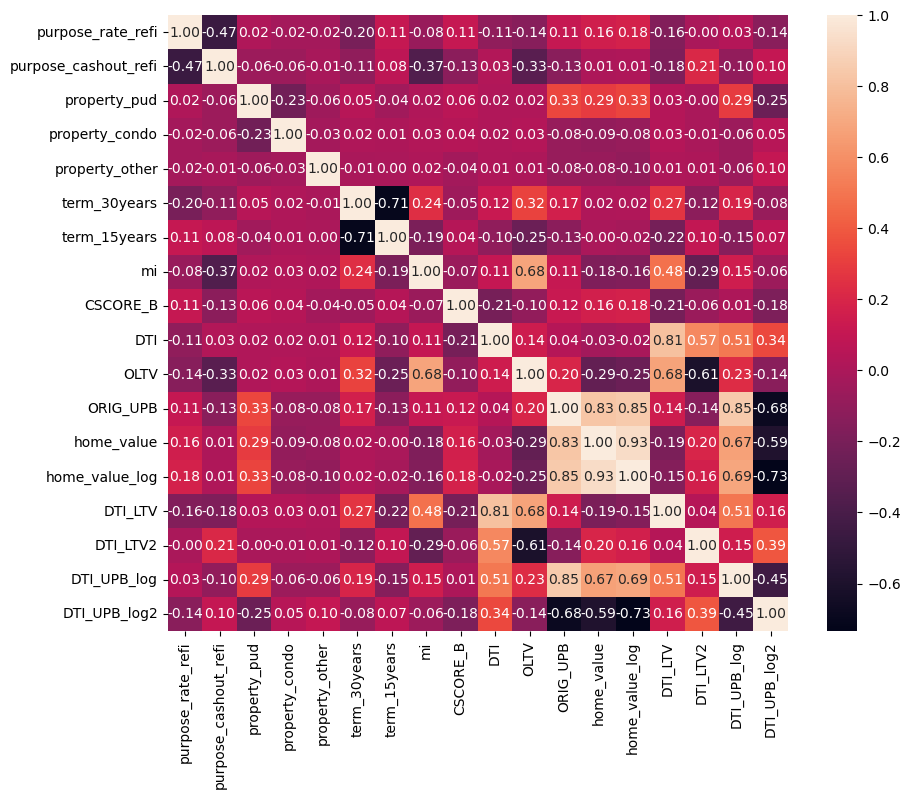

In [45]:
# visualize the correlation
fig=plt.figure(figsize=(10, 8))
sns.heatmap(df_select[df_select['seg']=='mod'][X].corr(), annot=True, fmt=".2f")

#### The following variables are removed because they show strong correlations (greater than 0.8) with other original features.
* home_value
* home_value_log
* DTI_LTV
* DTI_UPB_log

In [46]:
X=['purpose_rate_refi', 'purpose_cashout_refi', 'property_pud', 'property_condo', 'property_other',
   'term_30years', 'term_15years', 'mi', 'CSCORE_B', 'DTI', 'OLTV', 'ORIG_UPB', 'DTI_LTV2', 'DTI_UPB_log2']

X_train=df_select[df_select['seg']=='mod'][X]
y_train=df_select[df_select['seg']=='mod'][target]

X_test=df_select[df_select['seg']=='val'][X]
y_test=df_select[df_select['seg']=='val'][target]

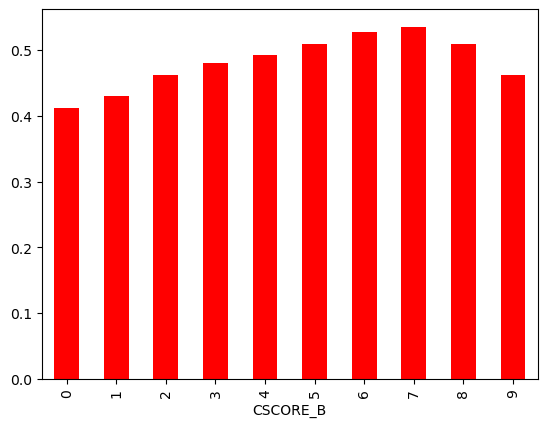

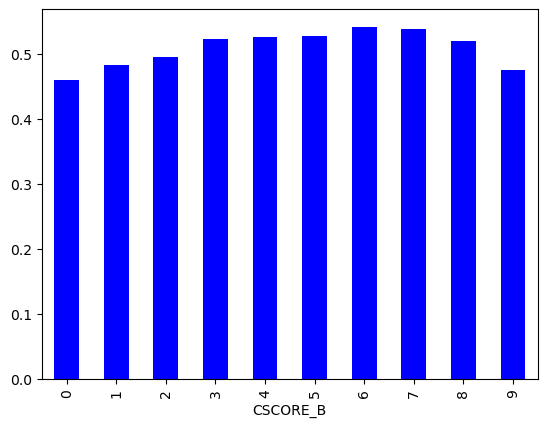

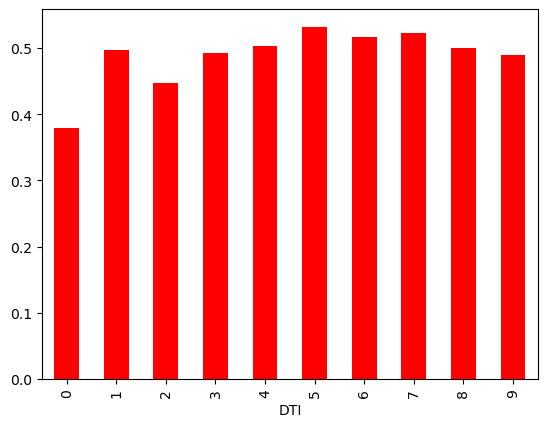

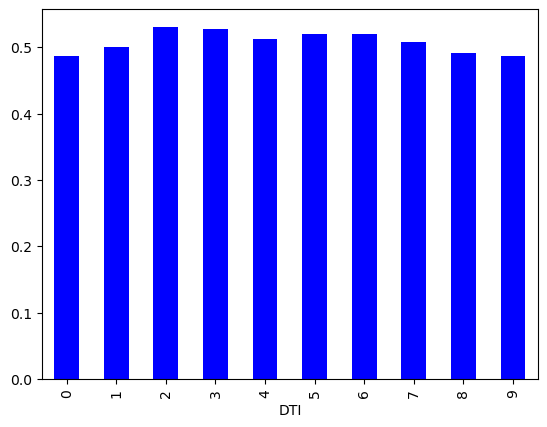

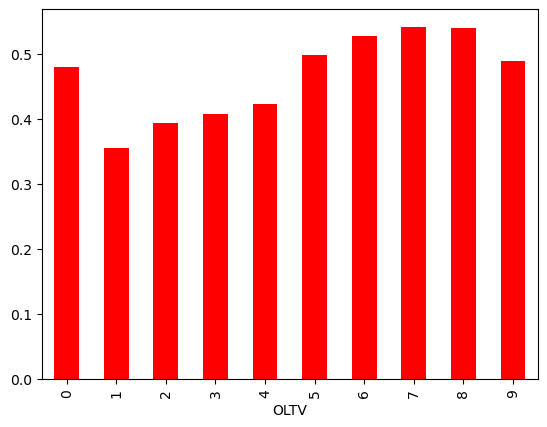

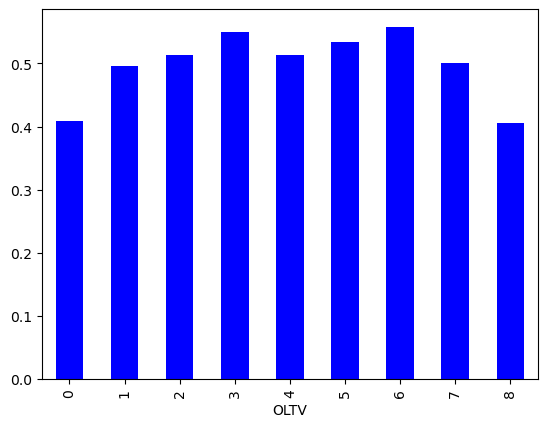

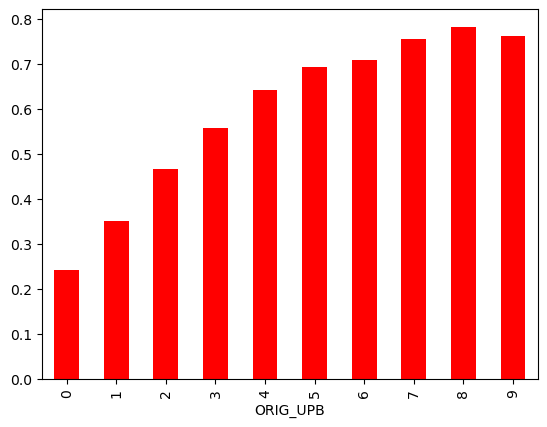

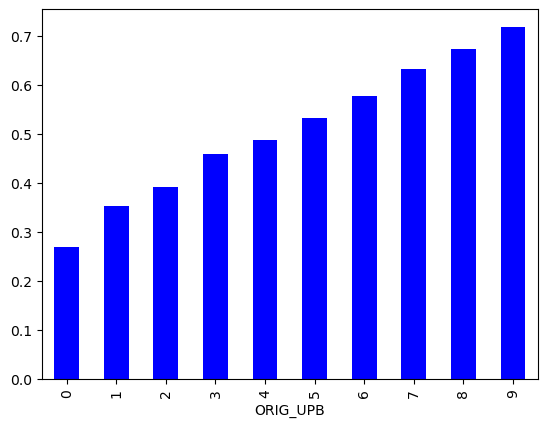

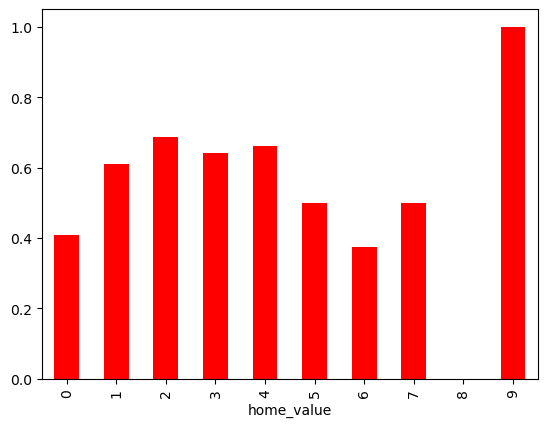

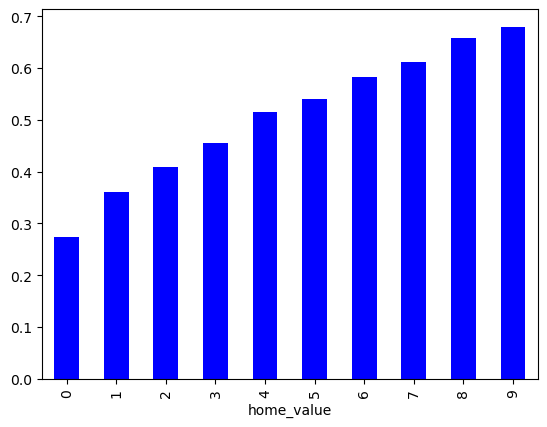

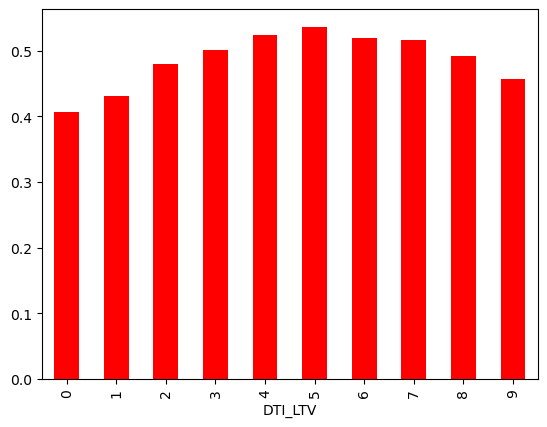

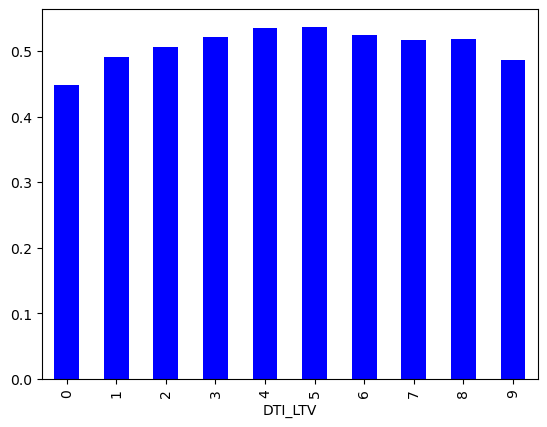

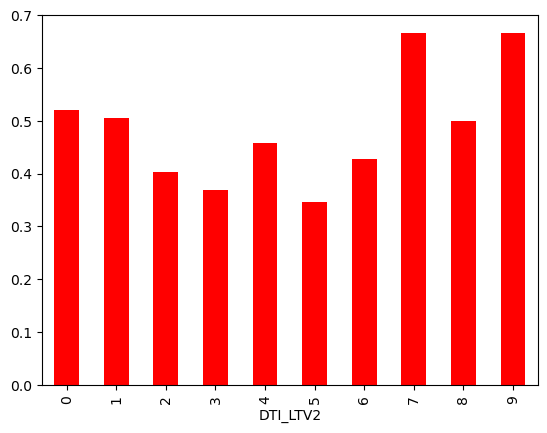

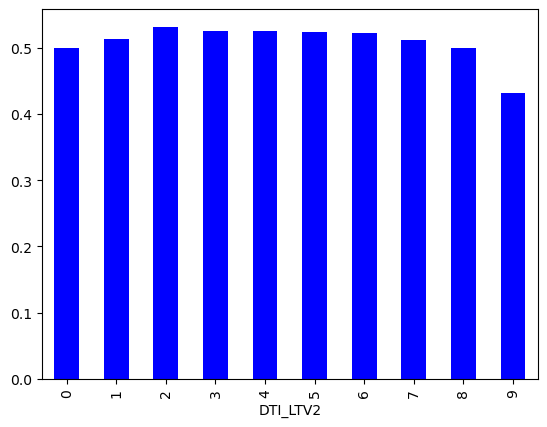

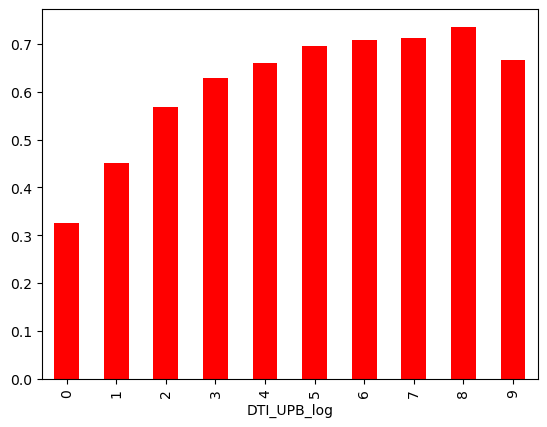

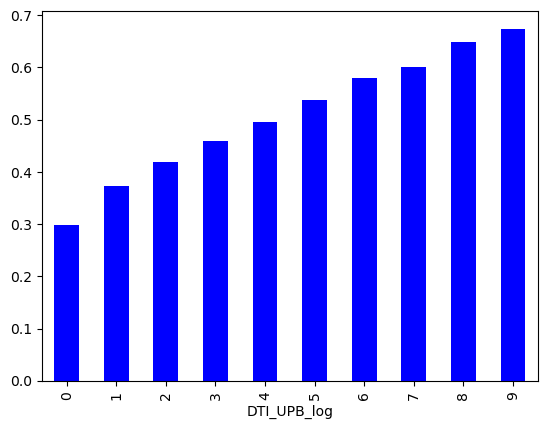

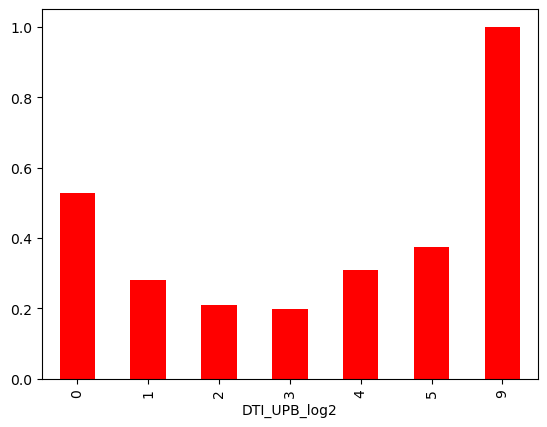

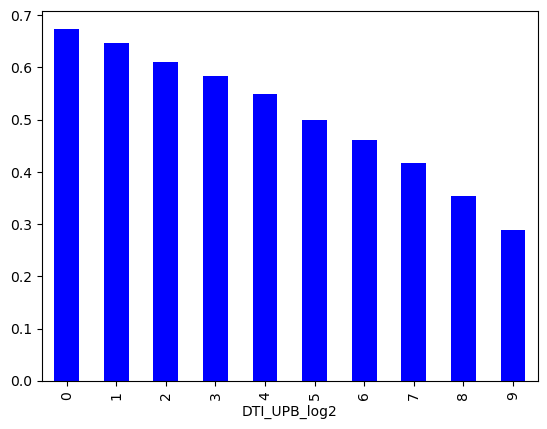

In [47]:
samp_mod=df_select[df_select['seg']=='mod']

def explore_numeric(x):
    # cut x into 10 bins according to its value
    samp_mod['value_ranks']=pd.cut(samp_mod[x], 10, labels=False)
    # print(samp_mod.groupby(['value_ranks']).size())
    # print(samp_mod[x].groupby(samp_mod['value_ranks']).mean())
    samp_mod[target].groupby(samp_mod['value_ranks']).mean().plot(kind='bar', color='red')
    plt.xlabel(x)
    plt.show()
    
    # cut x into 10 evenly distributed bins
    samp_mod['dist_ranks']=pd.qcut(samp_mod[x], 10, labels=False, duplicates="drop")
    # print(samp_mod.groupby(['dist_ranks']).size())
    # print(samp_mod[x].groupby(samp_mod['dist_ranks']).mean())
    samp_mod[target].groupby(samp_mod['dist_ranks']).mean().plot(kind='bar', color='blue')
    plt.xlabel(x)
    plt.show()

explore_numeric('CSCORE_B')
explore_numeric('DTI')
explore_numeric('OLTV')
explore_numeric('ORIG_UPB')
explore_numeric('home_value')
explore_numeric('DTI_LTV')
explore_numeric('DTI_LTV2')
explore_numeric('DTI_UPB_log')
explore_numeric('DTI_UPB_log2')

In [48]:
df_select.groupby('seg')['LOAN_ID'].count()

seg
mod    62810
val    42061
Name: LOAN_ID, dtype: int64

In [49]:
X_train[X].describe().T

count           mean            std           min  \
purpose_rate_refi     62810.0       0.388712       0.487462      0.000000   
purpose_cashout_refi  62810.0       0.254004       0.435303      0.000000   
property_pud          62810.0       0.312196       0.463393      0.000000   
property_condo        62810.0       0.102977       0.303932      0.000000   
property_other        62810.0       0.006639       0.081210      0.000000   
term_30years          62810.0       0.741076       0.438047      0.000000   
term_15years          62810.0       0.148989       0.356080      0.000000   
mi                    62810.0       0.282694       0.450312      0.000000   
CSCORE_B              62810.0     756.775482      42.387894    620.000000   
DTI                   62810.0      34.142859       9.570540      1.000000   
OLTV                  62810.0      73.933100      16.233119      7.000000   
ORIG_UPB              62810.0  253668.969909  124052.502113  12000.000000   
DTI_LTV2              62810.0       0.490647       0.216480      0.014286   
DTI_UPB_log2          62810.0       0.017908       0.013298      0.000794   

                              25%            50%            75%            max  
purpose_rate_refi          0.0000       0.000000       1.000000       1.000000  
purpose_cashout_refi       0.0000       0.000000       1.000000       1.000000  
property_pud               0.0000       0.000000       1.000000       1.000000  
property_condo             0.0000       0.000000       0.000000       1.000000  
property_other             0.0000       0.000000       0.000000       1.000000  
term_30years               0.0000       1.000000       1.000000       1.000000  
term_15years               0.0000       0.000000       0.000000       1.000000  
mi                         0.0000       0.000000       1.000000       1.000000  
CSCORE_B                 729.0000     766.000000     791.000000     835.000000  
DTI                       27.0000      35.000000      42.000000      50.000000  
OLTV                      65.0000      76.000000      85.000000      97.000000  
ORIG_UPB              156000.0000  236000.000000  336000.000000  766000.000000  
DTI_LTV2                   0.3600       0.461538       0.573333       4.500000  
DTI_UPB_log2               0.0096       0.014286       0.021951       0.366667

Accuracy: 0.614
Precision: 0.630
Recall: 0.594
Baseline: ROC AUC = 0.500
Logistic Regression - Prepayment: ROC AUC = 0.657


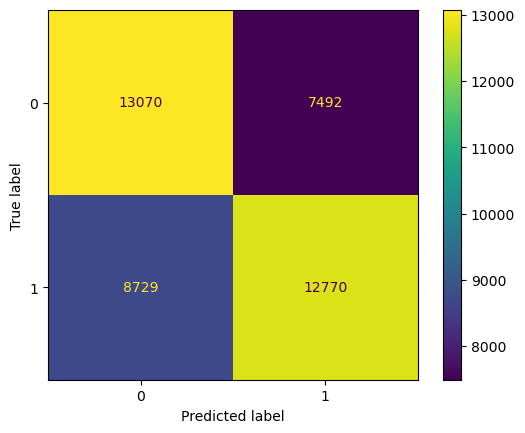

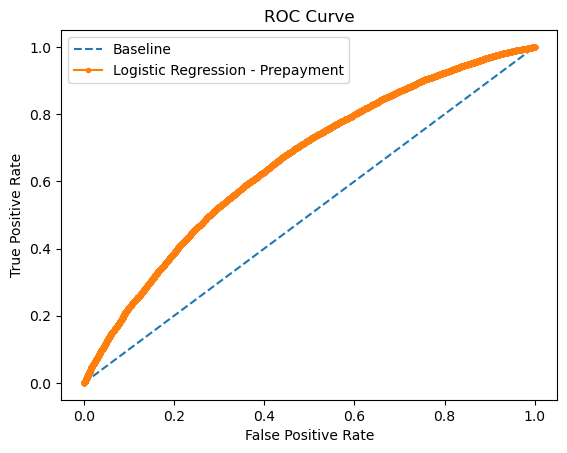

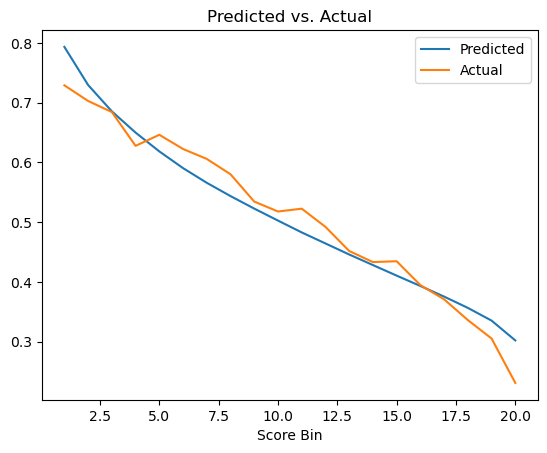

In [50]:
# 1) logistic regression
model=LogisticRegression()
model.fit(X_train, y_train)
preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='Logistic Regression - Prepayment'

LR=model_evaluation()

Accuracy: 0.616
Precision: 0.609
Recall: 0.693
Baseline: ROC AUC = 0.500
Decision Tree - Prepayment: ROC AUC = 0.652


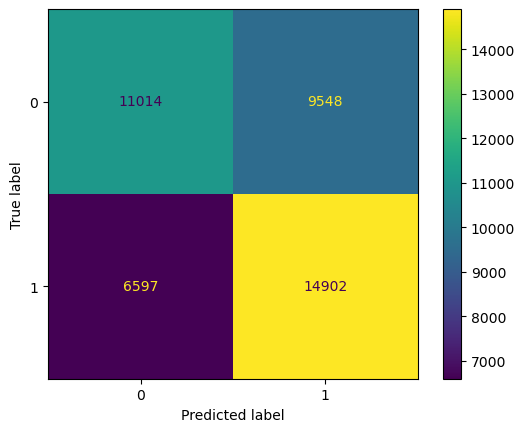

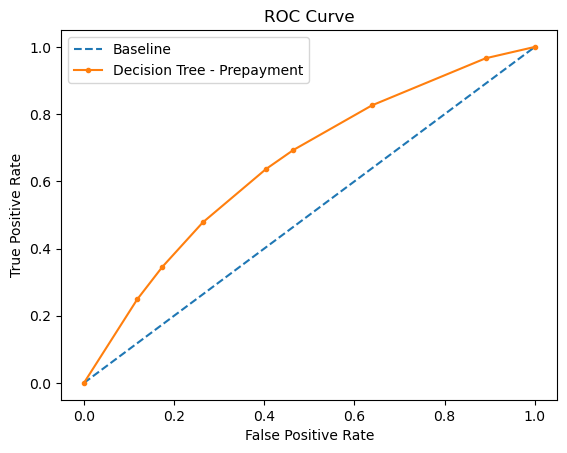

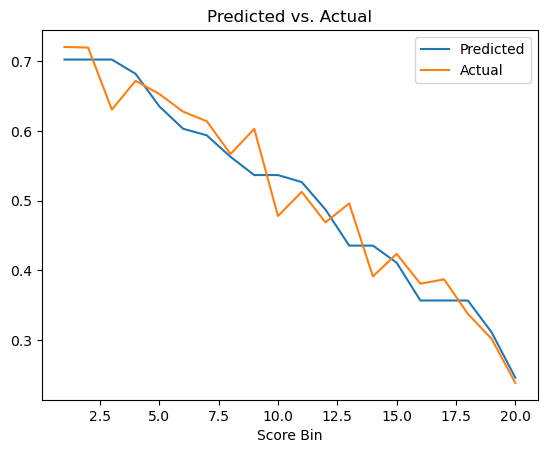

In [51]:
# 2) Decision Tree
model=DecisionTreeClassifier(max_depth=3, random_state=101, max_features=None, min_samples_leaf=3)
model.fit(X_train, y_train)
preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='Decision Tree - Prepayment'

DT=model_evaluation()

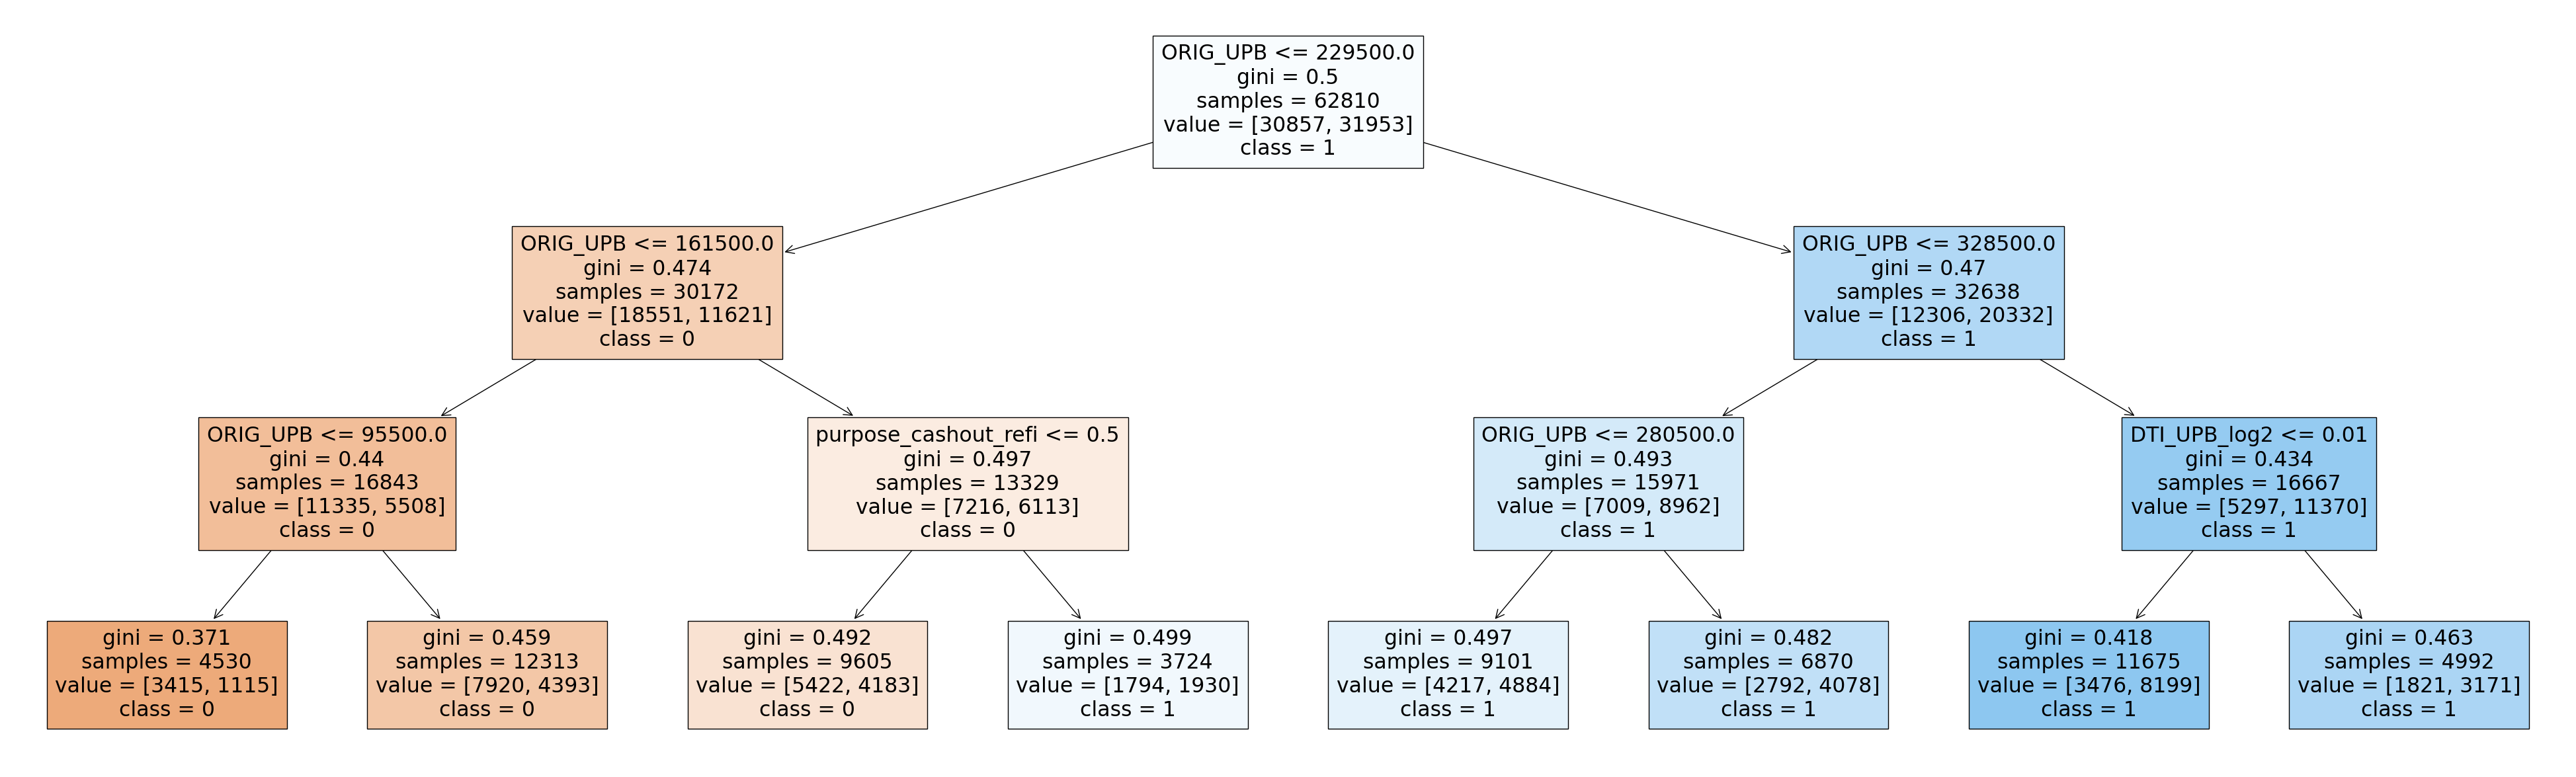

In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

model=DecisionTreeClassifier(max_depth=3, random_state=101, max_features=None, min_samples_leaf=3)
model=model.fit(X_train, y_train)

fig=plt.figure(figsize=(50, 15))
_ =tree.plot_tree(model, 
                  feature_names=X_train.columns, 
                  class_names=['0', '1'], filled=True)

Accuracy: 0.614
Precision: 0.635
Recall: 0.576
Baseline: ROC AUC = 0.500
Naive Bayes - Prepayment: ROC AUC = 0.649


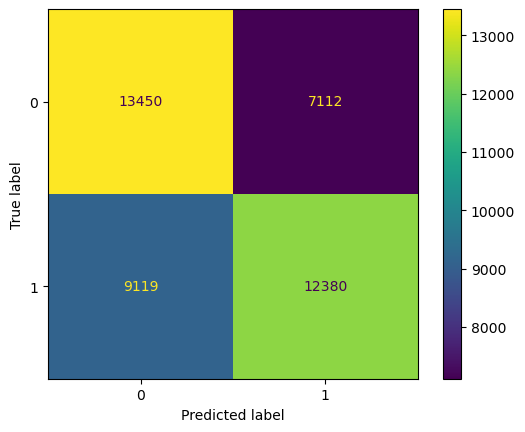

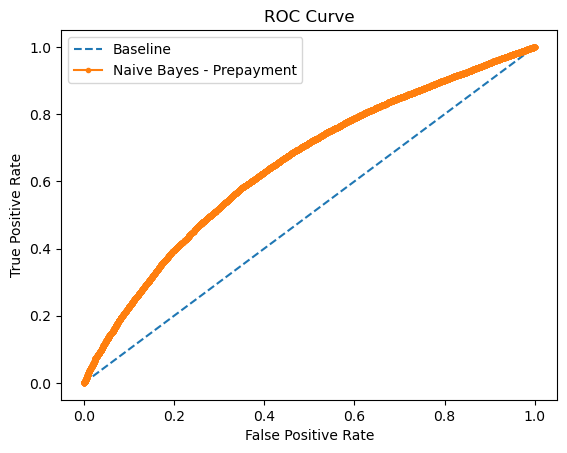

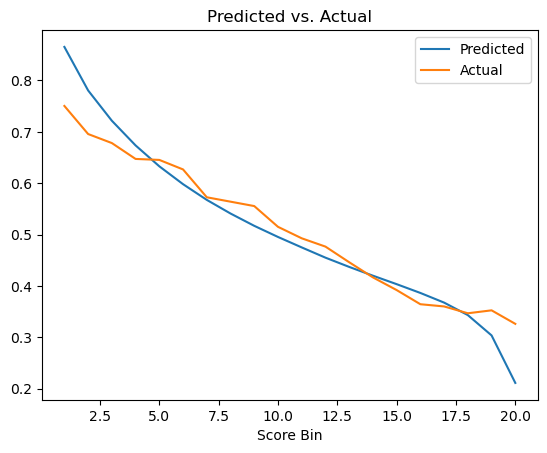

In [53]:
# 3) Naive Bayes
model=GaussianNB()
model.fit(X_train, y_train)
preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='Naive Bayes - Prepayment'

NB=model_evaluation()

Accuracy: 0.617
Precision: 0.616
Recall: 0.667
Baseline: ROC AUC = 0.500
Stochastic Gradient Descent - Prepayment: ROC AUC = 0.616


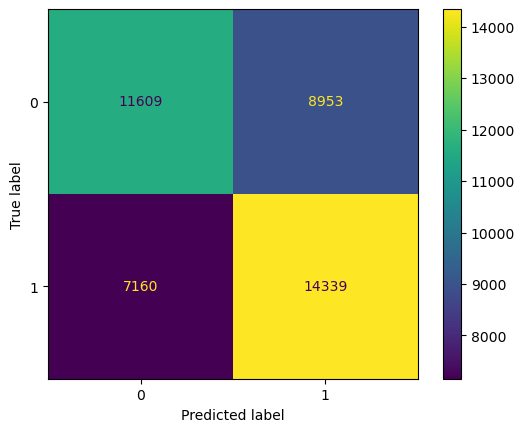

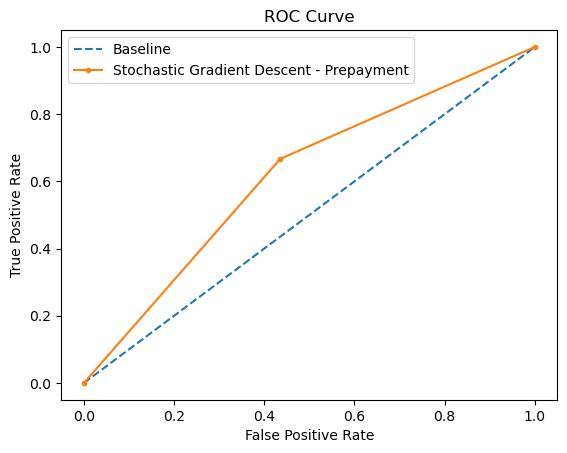

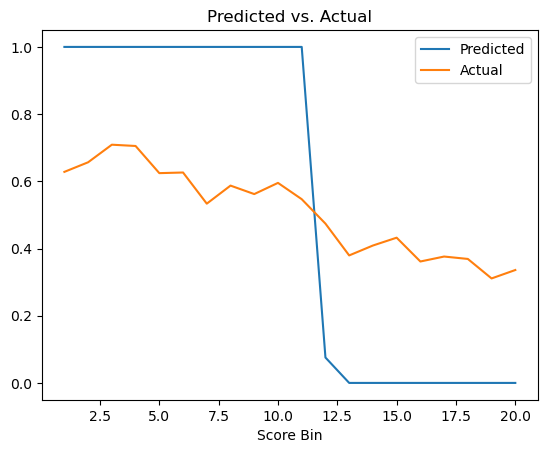

In [54]:
# 4) Stochastic Gradient Descent
model=SGDClassifier(loss='modified_huber', shuffle=True, random_state=101)
model.fit(X_train, y_train)
preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='Stochastic Gradient Descent - Prepayment'

SGD=model_evaluation()

Accuracy: 0.594
Precision: 0.598
Recall: 0.630
Baseline: ROC AUC = 0.500
KNN - Prepayment: ROC AUC = 0.623


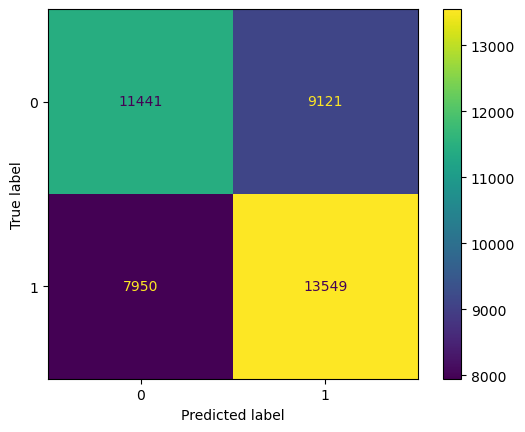

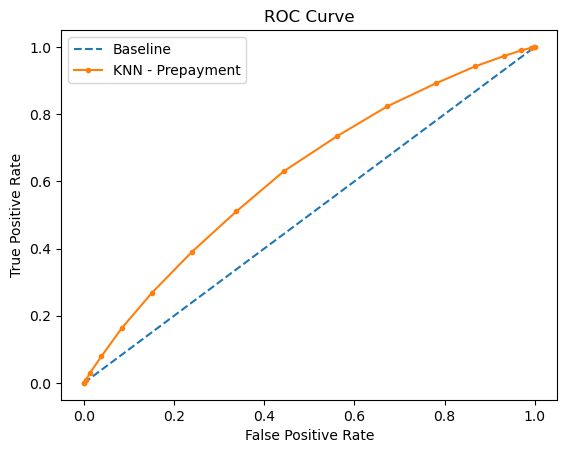

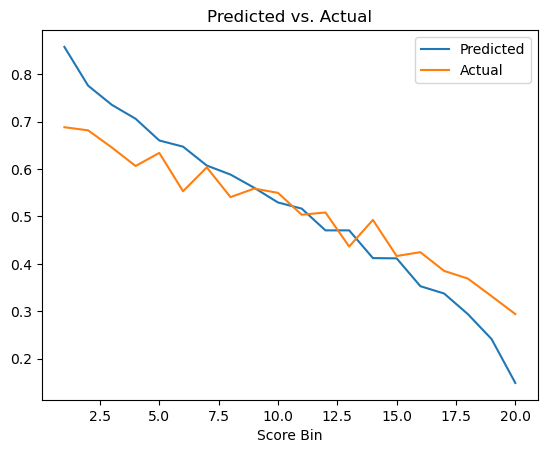

In [55]:
# 5) K Nearest Neighborhood (KNN)
model=KNeighborsClassifier(n_neighbors=17)
model.fit(X_train, y_train)
preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='KNN - Prepayment'

KNN=model_evaluation()

Accuracy: 0.621
Precision: 0.624
Recall: 0.653
Baseline: ROC AUC = 0.500
Light Gradient Boosting - Prepayment: ROC AUC = 0.666


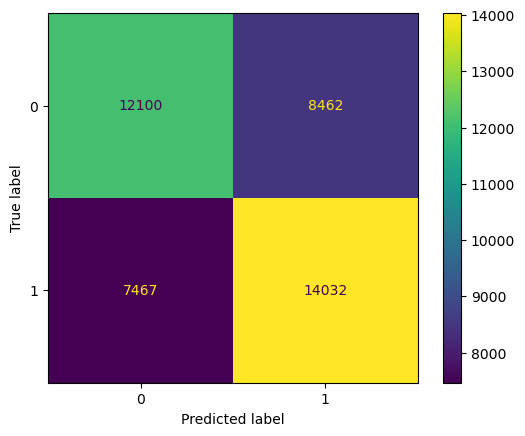

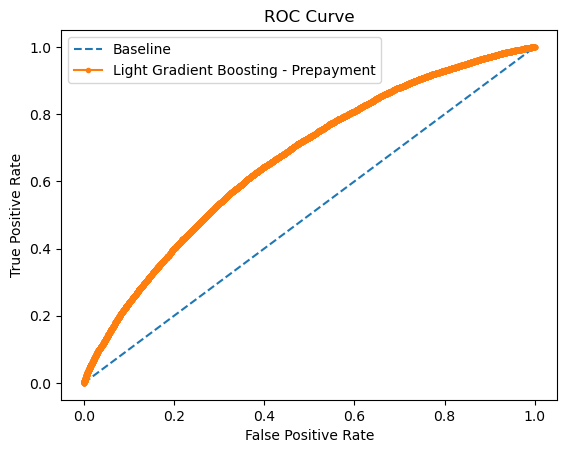

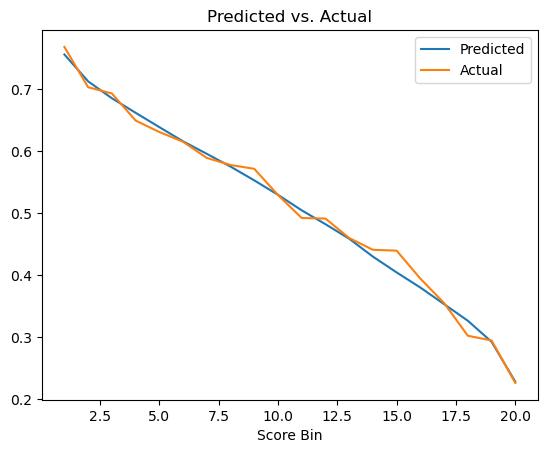

In [56]:
# 6) Light Gradint Boosting
model=GradientBoostingClassifier()
model.fit(X_train, y_train)
preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='Light Gradient Boosting - Prepayment'

LGB=model_evaluation()

Accuracy: 0.616
Precision: 0.618
Recall: 0.652
Baseline: ROC AUC = 0.500
XGBoost - Prepayment: ROC AUC = 0.657


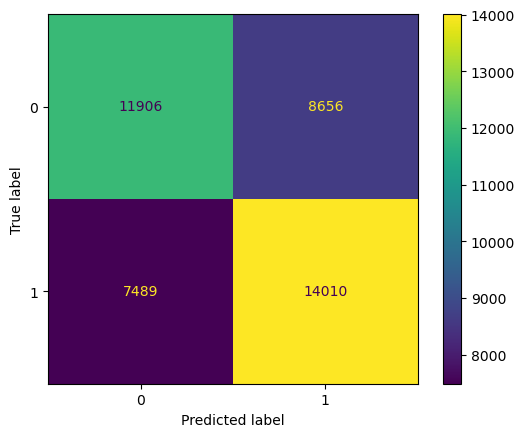

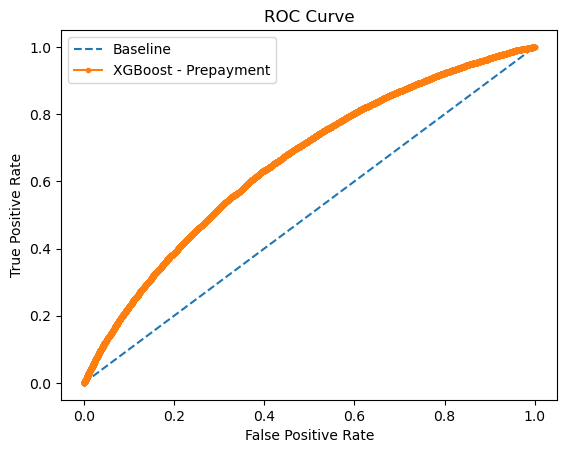

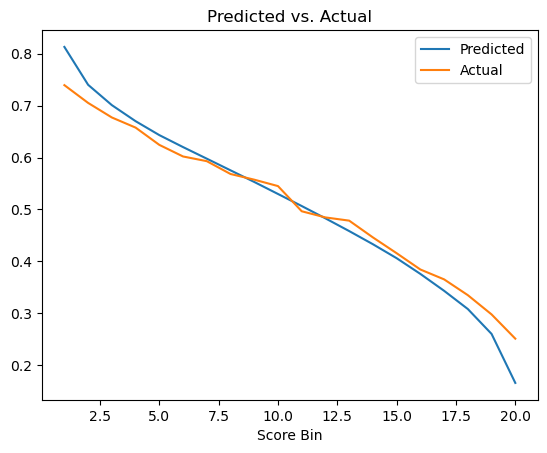

In [57]:
# 7) XGboost
model=XGBClassifier()
model.fit(X_train, y_train)
preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='XGBoost - Prepayment'

XGB=model_evaluation()

In [58]:
# 8) SVM of SVC
# from sklearn.svm import SVC

# model=SVC(probability=True)
# modelname='SVM'

# model.fit(X_train, y_train)

# preds=model.predict(X_test)
# probs=model.predict_proba(X_test)
# actuals=y_test.reset_index(drop=True)
# model_name='SVM - Prepayment'

# SVM=model_evaluation()

Accuracy: 0.594
Precision: 0.602
Recall: 0.607
Baseline: ROC AUC = 0.500
Random Forest - Prepayment: ROC AUC = 0.629


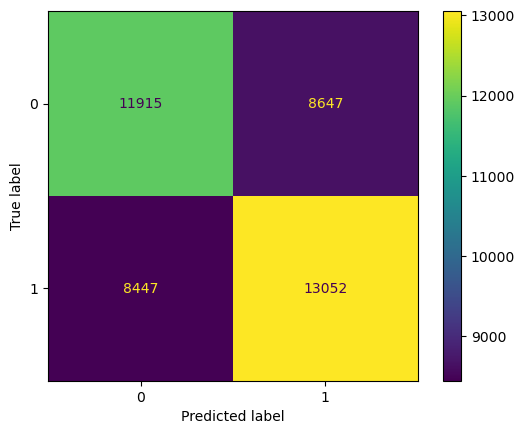

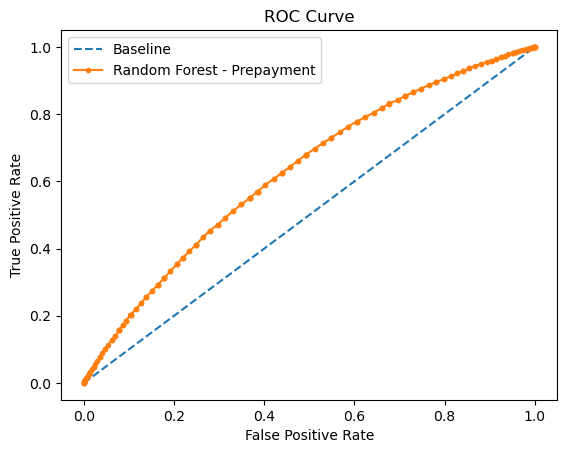

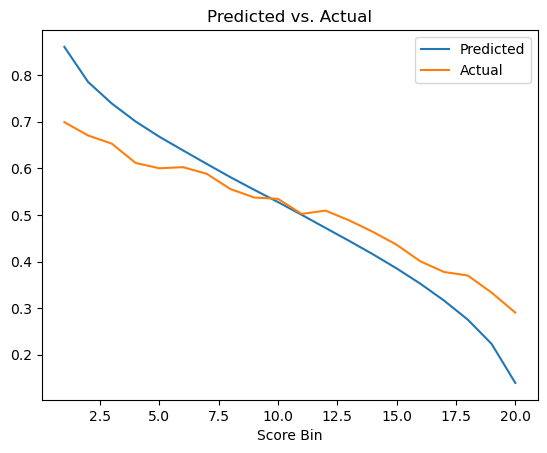

In [59]:
# 8) Random Forest
model=RandomForestClassifier()
model.fit(X_train, y_train)
preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='Random Forest - Prepayment'

RF=model_evaluation()

In [60]:
def model_evaluation():

    #ROC & AUC
    #Generate a baseline prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]

    #Predict probabilities
    lr_probs = model.predict_proba(X_test)

    #Keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]

    #Calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)

    #Summarize scores
    print('Baseline: ROC AUC = %.3f' % (ns_auc))
    print(model_name+': ROC AUC = %.3f' % (lr_auc))

    #Calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

    #Plot the roc curve for the model
    plt.figure()
    plt.plot(ns_fpr, ns_tpr, linestyle = '--', label = 'Baseline')
    plt.plot(lr_fpr, lr_tpr, marker = '.', label = model_name)

    #Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title("ROC Curve")
    plt.show()

    #Predicted vs. actual graphs
    actuals_y = pd.DataFrame(data = actuals, columns = [target])
    probs_y = pd.DataFrame(data = probs, columns = ['score1', 'score2'])
    actuals_probs = pd.concat([actuals_y, probs_y], axis = 1)
    num_bins = 20
    binlabels = list(range(0, num_bins))
    actuals_probs['score_bin'] = pd.qcut(actuals_probs['score2'].rank(method = 'first'), num_bins, labels = binlabels)
    actuals_probs['score_bin'] = num_bins - actuals_probs['score_bin'].astype(int)
    df_grp = actuals_probs.groupby('score_bin')['score2'].mean()
    df_grp.plot()
    df_grp2 = actuals_probs.groupby('score_bin')[target].mean()
    df_grp2.plot()
    plt.legend(["Predicted", "Actual"])
    plt.xlabel('Score Bin')
    plt.title("Predicted vs. Actual")
    
    # save AUC ROC and use it as the weight in the ensemble method later
    return(lr_auc)

Baseline: ROC AUC = 0.500
Ensemble Learning - Weighted Average - Prepayment: ROC AUC = 0.629


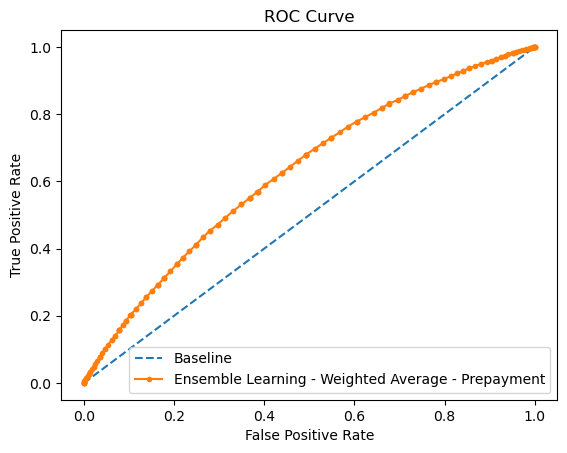

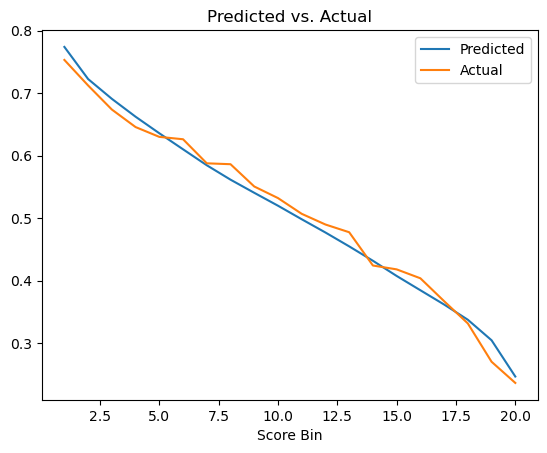

In [61]:
model_LR=LogisticRegression()
model_DT = DecisionTreeClassifier(max_depth = 3, random_state = 101, max_features = None, min_samples_leaf = 3)
model_NB=GaussianNB()
model_SGD=SGDClassifier(loss='modified_huber', shuffle=True, random_state=101)
model_KNN=KNeighborsClassifier(n_neighbors=15)
model_LGB = GradientBoostingClassifier()
model_XGB = XGBClassifier()
model_RF = RandomForestClassifier()

# train the model with the modeling sample
model_LR.fit(X_train, y_train)
model_DT.fit(X_train, y_train)
model_NB.fit(X_train, y_train)
model_SGD.fit(X_train, y_train)
model_KNN.fit(X_train, y_train)
model_LGB.fit(X_train, y_train)
model_XGB.fit(X_train, y_train)
model_RF.fit(X_train, y_train)

# score the validation sample 
Prob_LR = model_LR.predict_proba(X_test)
Prob_DT = model_DT.predict_proba(X_test)
Prob_NB = model_NB.predict_proba(X_test)
Prob_SGD = model_SGD.predict_proba(X_test)
Prob_KNN = model_KNN.predict_proba(X_test)
Prob_LGB = model_LGB.predict_proba(X_test)
Prob_XGB = model_XGB.predict_proba(X_test)
Prob_RF = model_RF.predict_proba(X_test)

# Use weight_exponent to reward the algorithms with higher ROC
weight_exponent = 2

w1 = LR**weight_exponent
w2 = DT**weight_exponent
w3 = NB**weight_exponent
w4 = SGD**weight_exponent
w5 = KNN**weight_exponent
w6 = LGB**weight_exponent
w7 = XGB**weight_exponent
w8 = RF**weight_exponent

probs = (Prob_LR*w1 + Prob_DT*w2 + Prob_NB*w3 + Prob_KNN*w5 + Prob_LGB*w6 + Prob_XGB*w7 + Prob_RF*w8) / (w1+w2+w3+w5+w6+w7+w8)

actuals = y_test.reset_index(drop=True)
model_name = "Ensemble Learning - Weighted Average - Prepayment"

EL_weighted_average = model_evaluation()

In [62]:
# append prepayment score with LOAN ID
prepay_score=pd.DataFrame(probs, columns=['score1', 'score2']).reset_index()
LOAN_ID=df_select[df_select['seg']=='val']['LOAN_ID'].reset_index()

prepay_file=pd.DataFrame({'LOAN_ID': LOAN_ID['LOAN_ID'], 'Predicted_prepay': prepay_score['score2']})
prepay_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42061 entries, 0 to 42060
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   LOAN_ID           42061 non-null  int64  
 1   Predicted_prepay  42061 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 657.3 KB


In [63]:
prepay_file.head()

LOAN_ID  Predicted_prepay
0  98836743          0.457468
1  98837067          0.639922
2  98837191          0.497542
3  98837238          0.391004
4  98837371          0.366512

#### If ensemble does not outperform any single ML algorithm, it does not have to be chosen as the final choice of the model. 

# Step 8: Payment Default Model (bad rate model/risk model)
#### define the target

In [64]:
target='bad'

In [65]:
X=['purpose_rate_refi', 'purpose_cashout_refi', 'property_pud', 'property_condo', 'property_other',
   'term_30years', 'term_15years', 'mi', 'CSCORE_B', 'DTI', 'OLTV', 'ORIG_UPB', 'home_value', 'home_value_log',
   'DTI_LTV2', 'DTI_UPB_log2']

X_train=df_select[df_select['seg']=='mod'][X]
y_train=df_select[df_select['seg']=='mod'][target]

X_test=df_select[df_select['seg']=='val'][X]
y_test=df_select[df_select['seg']=='val'][target]

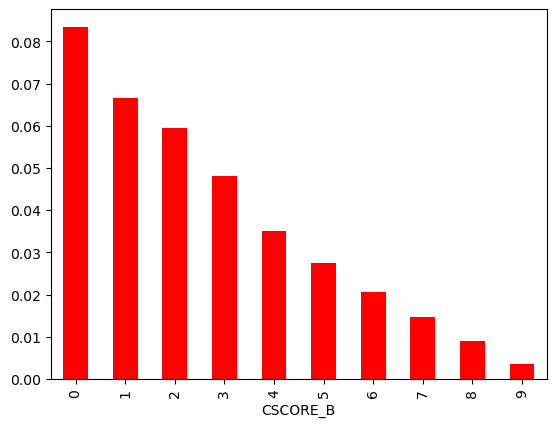

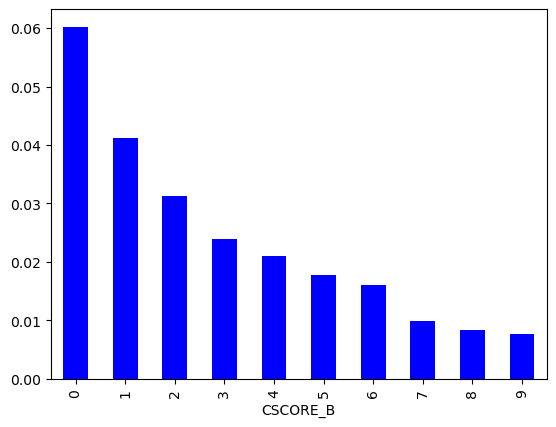

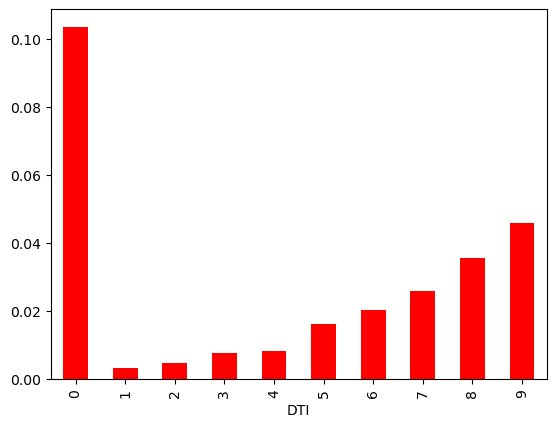

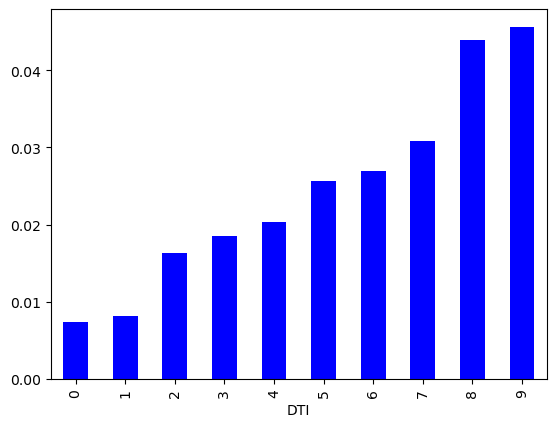

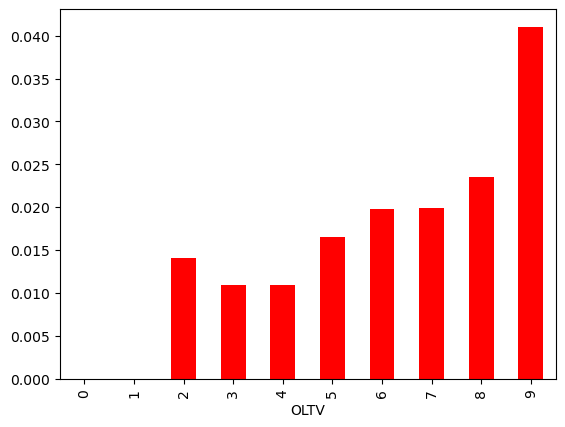

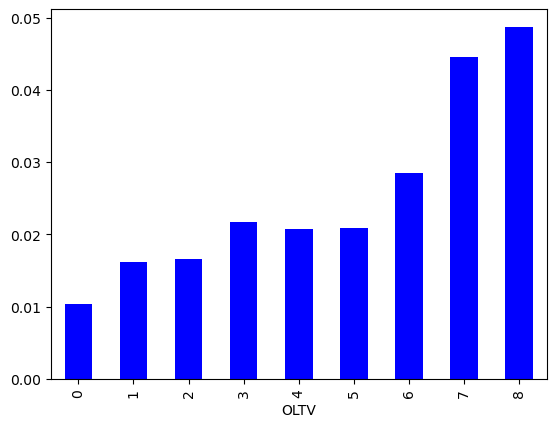

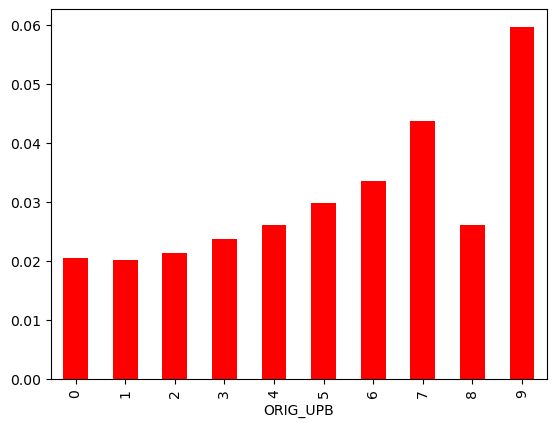

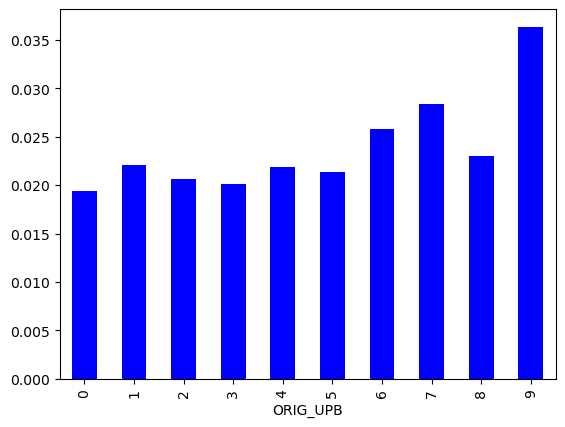

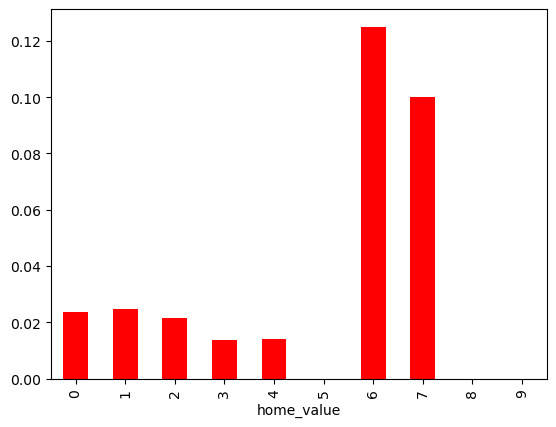

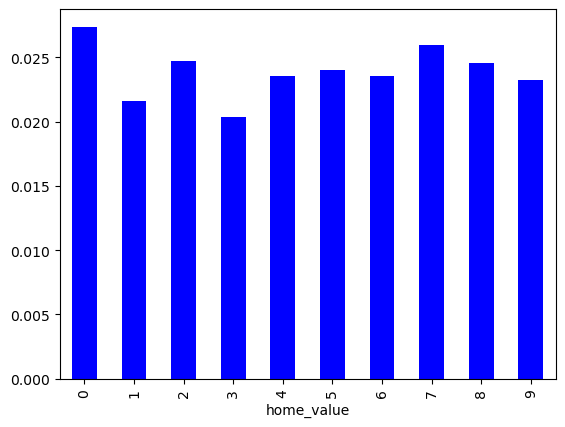

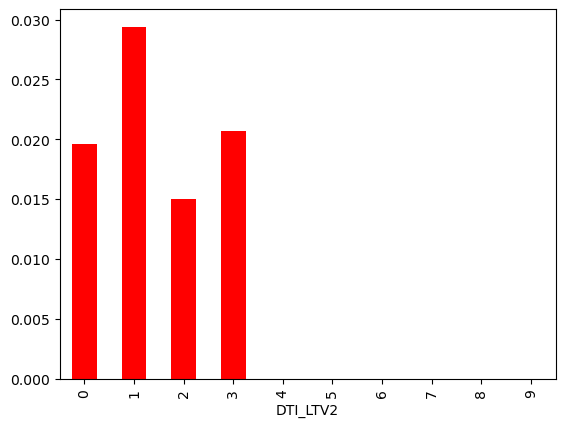

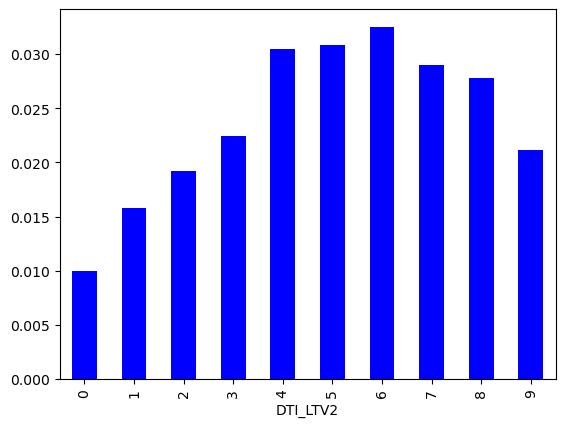

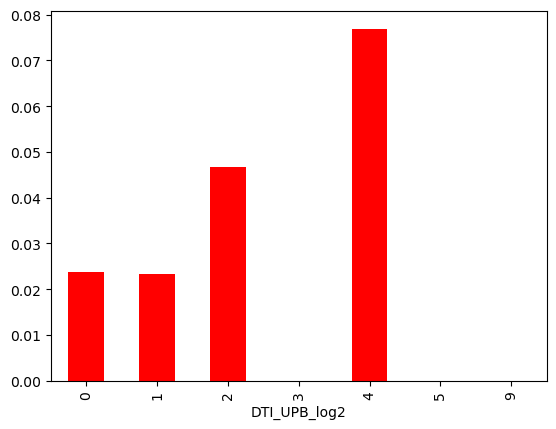

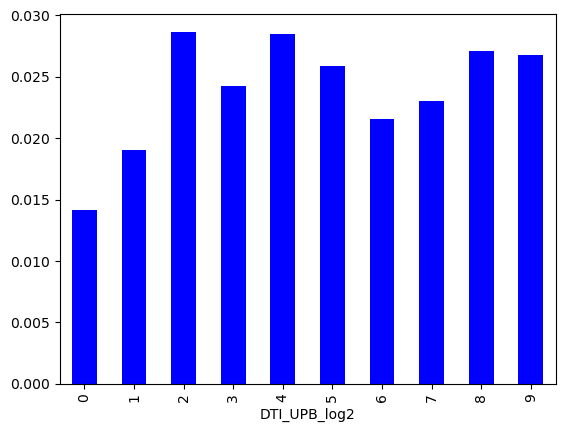

In [66]:
samp_mod=df_select[df_select['seg']=='mod']

def explore_numeric(x):
    # cut x into 10 bins according to its value
    samp_mod['value_ranks']=pd.cut(samp_mod[x], 10, labels=False)
    # print(samp_mod.groupby(['value_ranks']).size())
    # print(samp_mod[x].groupby(samp_mod['value_ranks']).mean())
    samp_mod[target].groupby(samp_mod['value_ranks']).mean().plot(kind='bar', color='red')
    plt.xlabel(x)
    plt.show()
    
    # cut x into 10 evenly distributed bins
    samp_mod['dist_ranks']=pd.qcut(samp_mod[x], 10, labels=False, duplicates="drop")
    # print(samp_mod.groupby(['dist_ranks']).size())
    # print(samp_mod[x].groupby(samp_mod['dist_ranks']).mean())
    samp_mod[target].groupby(samp_mod['dist_ranks']).mean().plot(kind='bar', color='blue')
    plt.xlabel(x)
    plt.show()

explore_numeric('CSCORE_B')
explore_numeric('DTI')
explore_numeric('OLTV')
explore_numeric('ORIG_UPB')
explore_numeric('home_value')
explore_numeric('DTI_LTV2')
explore_numeric('DTI_UPB_log2')

Baseline: ROC AUC = 0.500
Logistic Regression - Default: ROC AUC = 0.695


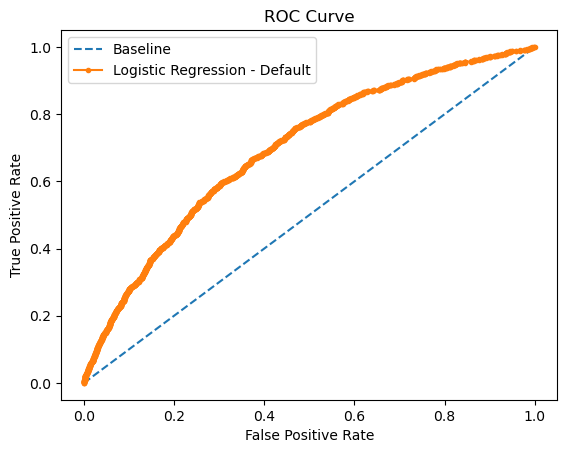

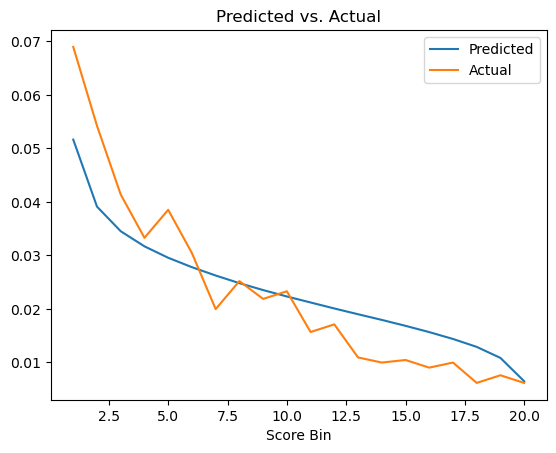

In [67]:
# 1) logistic regression
model=LogisticRegression()
model.fit(X_train, y_train)
preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='Logistic Regression - Default'

LR=model_evaluation()

Baseline: ROC AUC = 0.500
Decision Tree - Default: ROC AUC = 0.676


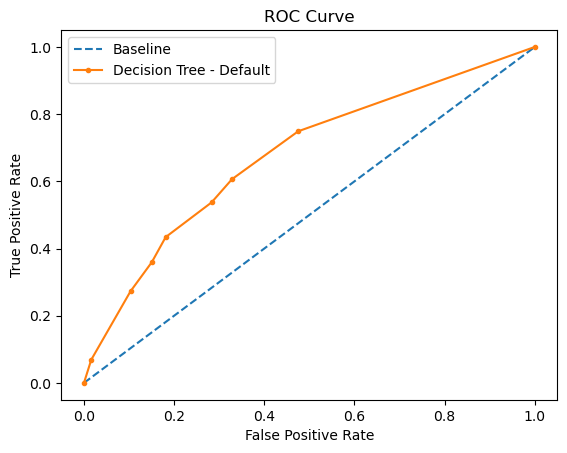

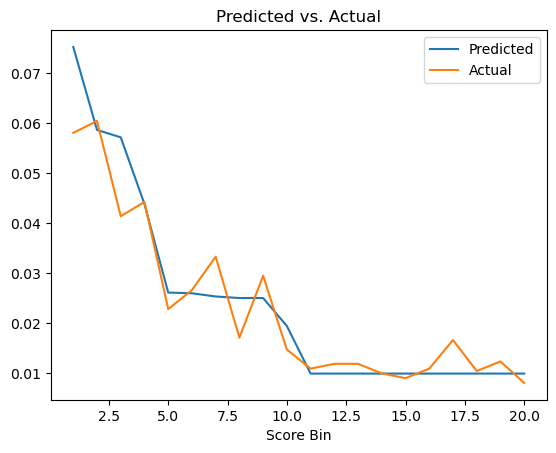

In [68]:
# 2) Decision Tree
model=DecisionTreeClassifier(max_depth=3, random_state=101, max_features=None, min_samples_leaf=3)
model.fit(X_train, y_train)
preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='Decision Tree - Default'

DT=model_evaluation()

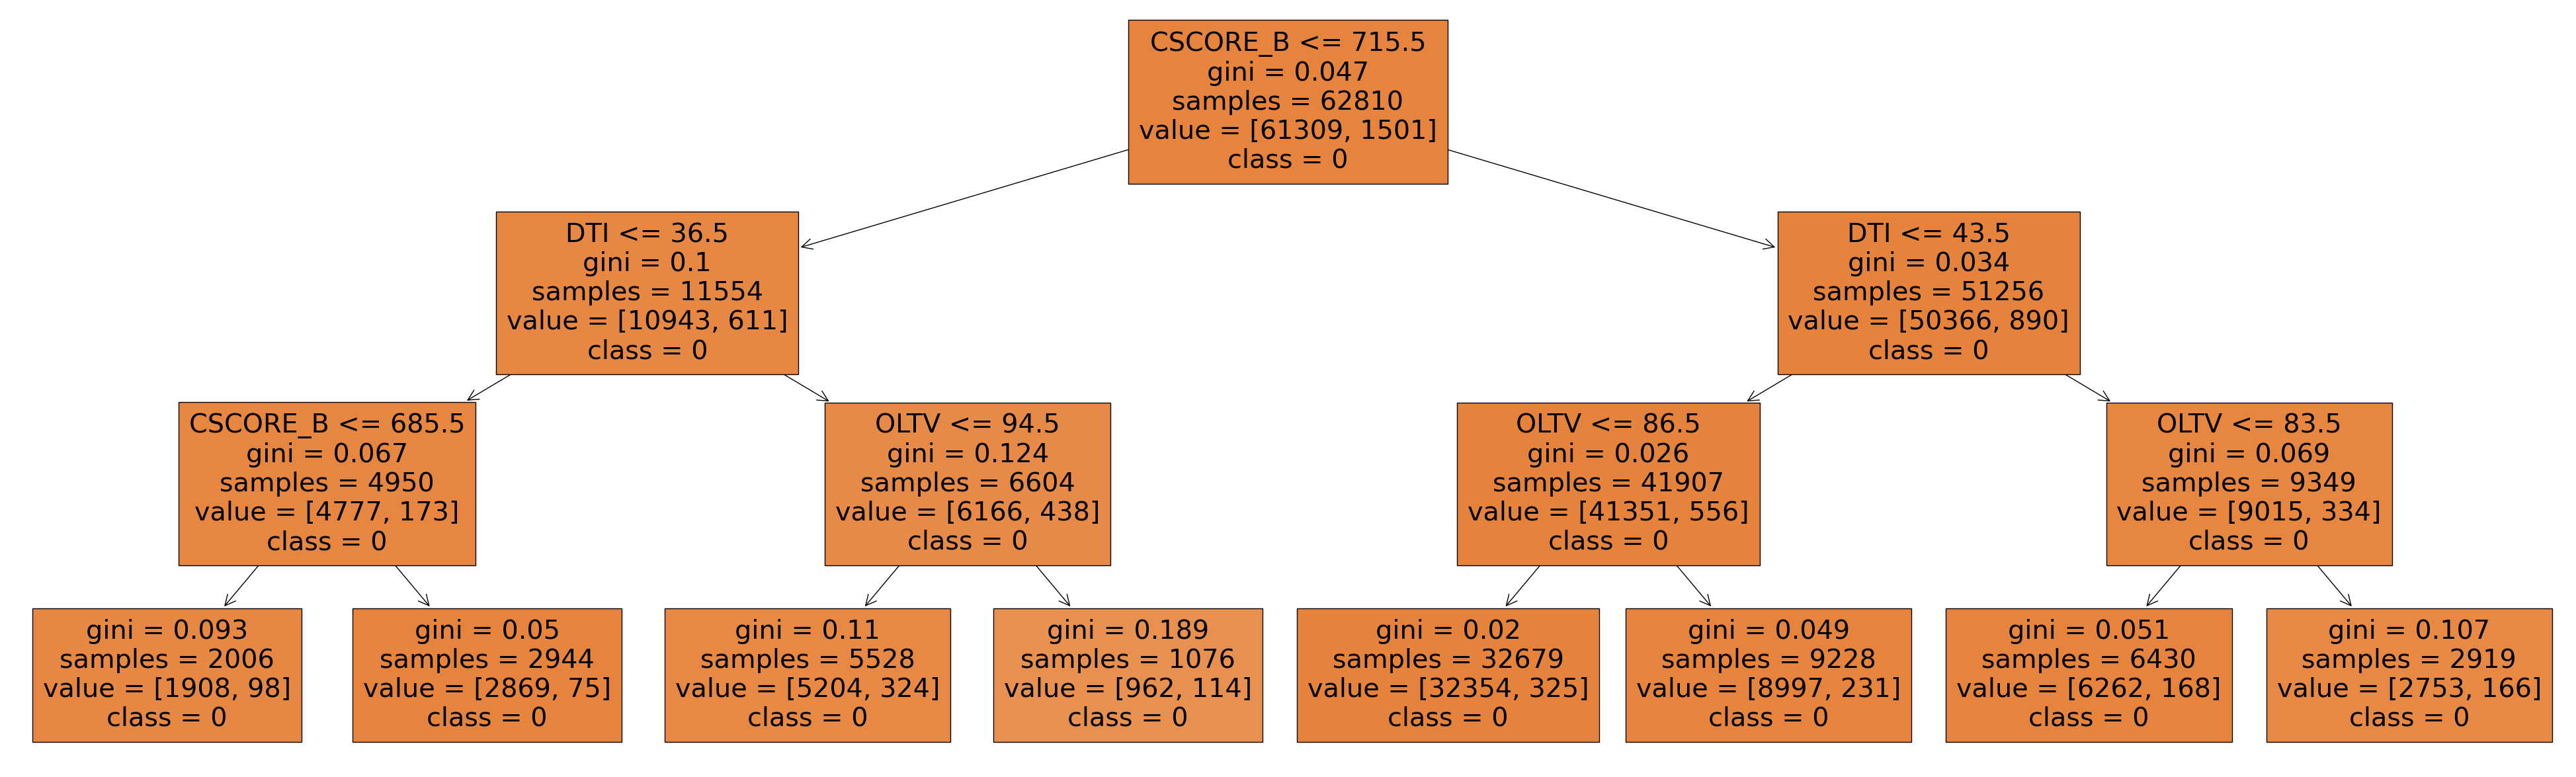

In [69]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

model=DecisionTreeClassifier(max_depth=3, random_state=101, max_features=None, min_samples_leaf=3)
model=model.fit(X_train, y_train)

fig=plt.figure(figsize=(50, 15))
_ =tree.plot_tree(model, 
                  feature_names=X_train.columns, 
                  class_names=['0', '1'], filled=True)

Baseline: ROC AUC = 0.500
Naive Bayes - Default: ROC AUC = 0.730


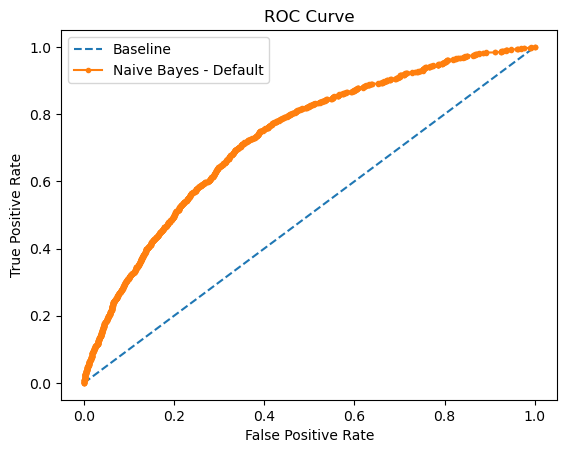

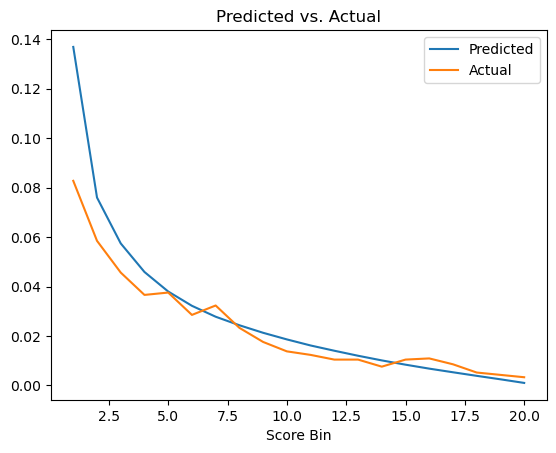

In [70]:
# 3) Naive Bayes
model=GaussianNB()
model.fit(X_train, y_train)
preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='Naive Bayes - Default'

NB=model_evaluation()

Baseline: ROC AUC = 0.500
Stochastic Gradient Descent - Default: ROC AUC = 0.500


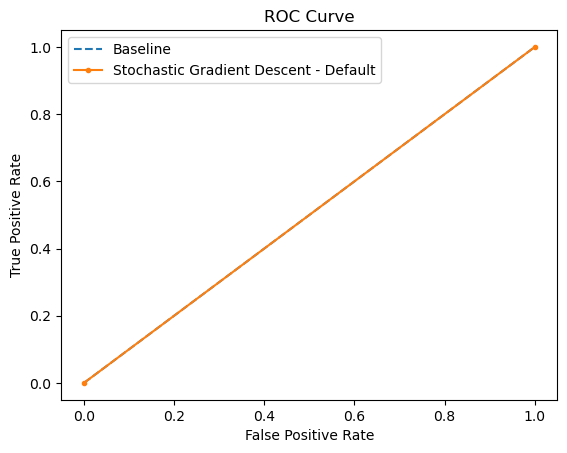

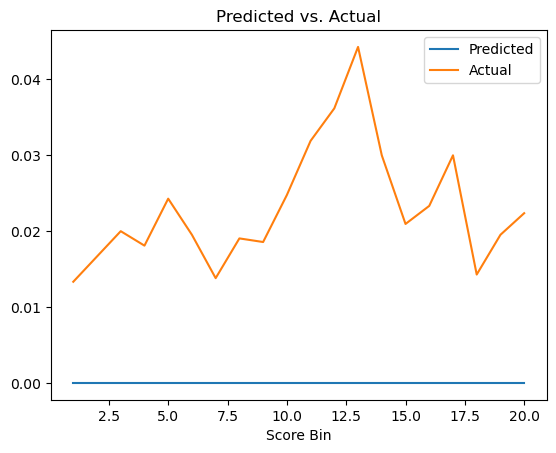

In [71]:
# 4) Stochastic Gradient Descent
model=SGDClassifier(loss='modified_huber', shuffle=True, random_state=101)
model.fit(X_train, y_train)
preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='Stochastic Gradient Descent - Default'

SGD=model_evaluation()

Baseline: ROC AUC = 0.500
KNN - Default: ROC AUC = 0.530


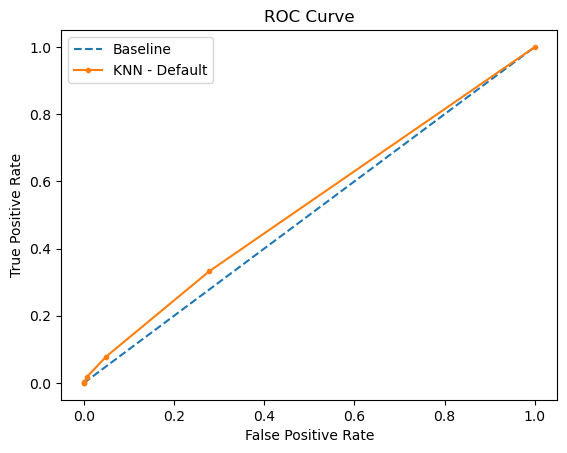

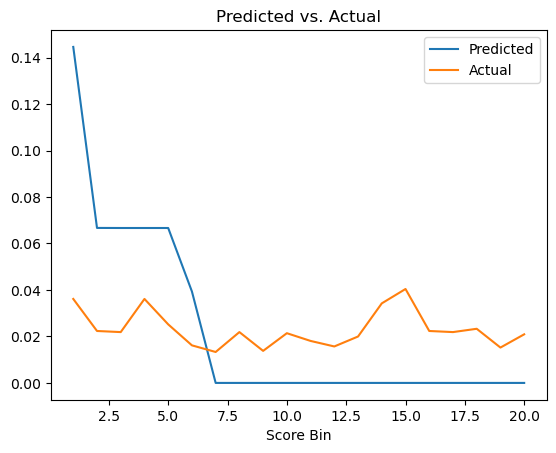

In [72]:
# 5) K Nearest Neighborhood (KNN)
model=KNeighborsClassifier(n_neighbors=15)
model.fit(X_train, y_train)
preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='KNN - Default'

KNN=model_evaluation()

Baseline: ROC AUC = 0.500
Light Gradient Boosting - Default: ROC AUC = 0.734


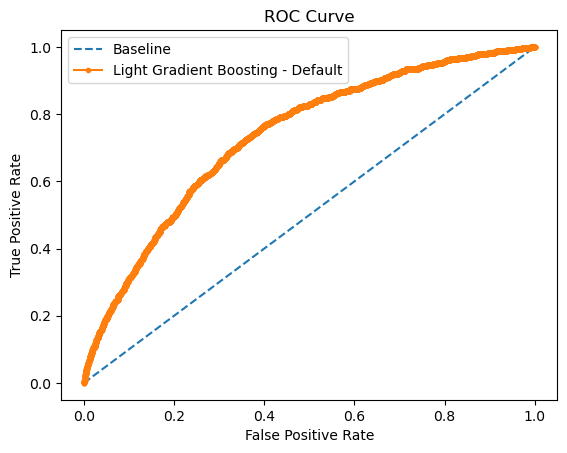

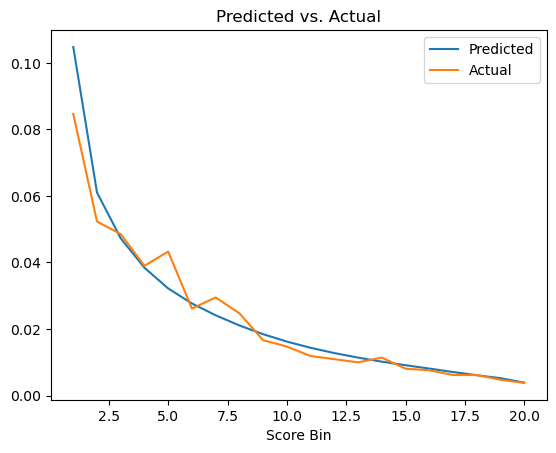

In [73]:
# 6) Light Gradint Boosting
model=GradientBoostingClassifier()
model.fit(X_train, y_train)
preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='Light Gradient Boosting - Default'

LGB=model_evaluation()

Baseline: ROC AUC = 0.500
XGBoost - Default: ROC AUC = 0.710


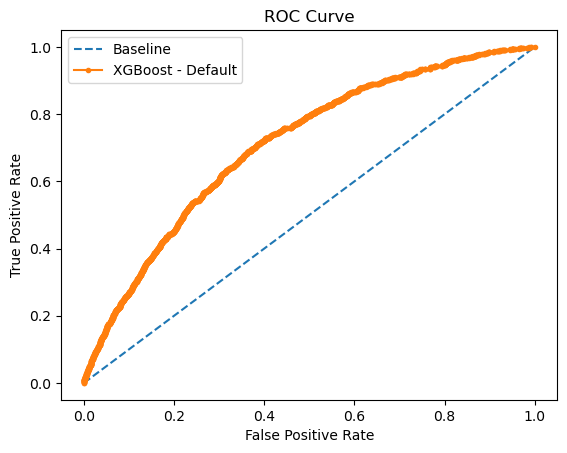

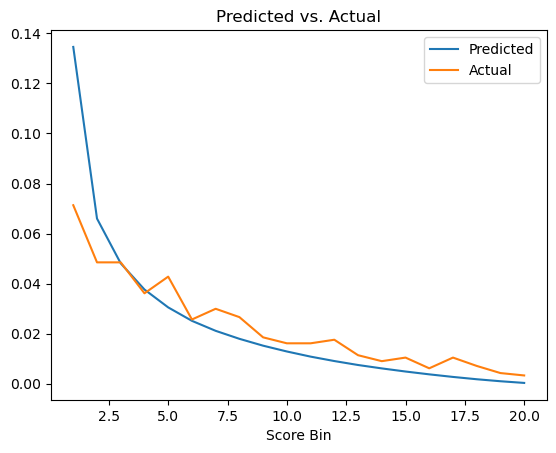

In [74]:
# 7) XGboost
model=XGBClassifier()
model.fit(X_train, y_train)
preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='XGBoost - Default'

XGB=model_evaluation()

Baseline: ROC AUC = 0.500
Random Forest - Default: ROC AUC = 0.649


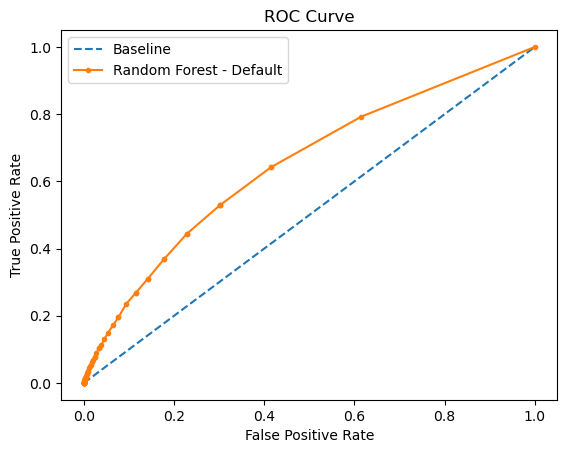

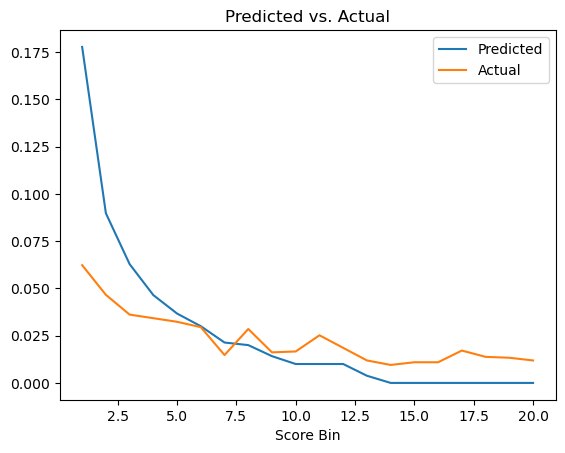

In [75]:
# 8) Random Forest
model=RandomForestClassifier()
model.fit(X_train, y_train)
preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='Random Forest - Default'

RF=model_evaluation()

Baseline: ROC AUC = 0.500
Ensemble Learning - Weighted Average: ROC AUC = 0.649


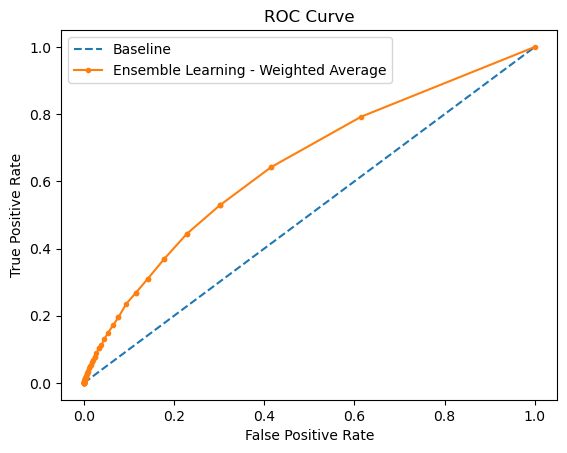

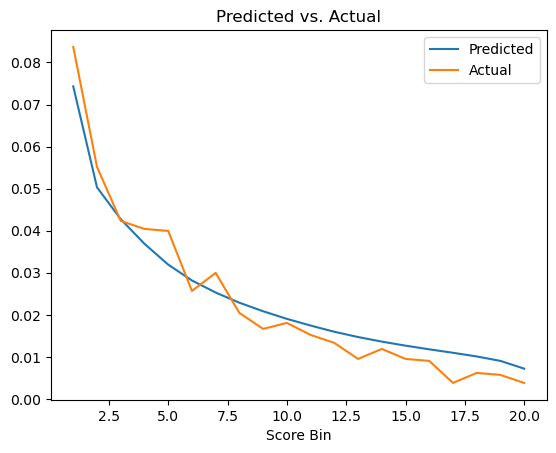

In [76]:
model_LR = LogisticRegression()
model_DT = DecisionTreeClassifier(max_depth = 3, random_state = 101, max_features = None, min_samples_leaf = 3)
model_NB = GaussianNB()
model_SGD = SGDClassifier(loss='modified_huber', shuffle=True, random_state=101)
model_KNN = KNeighborsClassifier(n_neighbors=15)
model_LGB = GradientBoostingClassifier()
model_XGB = XGBClassifier()
model_RF = RandomForestClassifier()

model_LR.fit(X_train, y_train)
model_DT.fit(X_train, y_train)
model_NB.fit(X_train, y_train)
model_SGD.fit(X_train, y_train)
model_KNN.fit(X_train, y_train)
model_LGB.fit(X_train, y_train)
model_XGB.fit(X_train, y_train)
model_RF.fit(X_train, y_train)

Prob_LR = model_LR.predict_proba(X_test)
Prob_DT = model_DT.predict_proba(X_test)
Prob_NB = model_NB.predict_proba(X_test)
Prob_SGD = model_SGD.predict_proba(X_test)
Prob_KNN = model_KNN.predict_proba(X_test)
Prob_LGB = model_LGB.predict_proba(X_test)
Prob_XGB = model_XGB.predict_proba(X_test)
Prob_RF = model_RF.predict_proba(X_test)

# Use weight_exponent to reward the algorithms with higher ROC
weight_exponent = 2

w1 = LR**weight_exponent
w2 = DT**weight_exponent
w3 = NB**weight_exponent
w4 = SGD**weight_exponent
w5 = KNN**weight_exponent
w6 = LGB**weight_exponent
w7 = XGB**weight_exponent
w8 = RF**weight_exponent

probs = (Prob_LR*w1 + Prob_DT*w2 + Prob_LGB*w6) / (w1+w2+w6)

actuals = y_test.reset_index(drop=True)
model_name = "Ensemble Learning - Weighted Average"

EL_weighted_average = model_evaluation()

In [77]:
# append prepayment score with LOAN ID
default_score=pd.DataFrame(probs, columns=['score1', 'score2']).reset_index()
LOAN_ID=df_select[df_select['seg']=='val']['LOAN_ID'].reset_index()

default_file=pd.DataFrame({'LOAN_ID': LOAN_ID['LOAN_ID'], 'Predicted_default': default_score['score2']})
default_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42061 entries, 0 to 42060
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LOAN_ID            42061 non-null  int64  
 1   Predicted_default  42061 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 657.3 KB


# Step 9: Combine two scores

In [78]:
two_scores=pd.merge(prepay_file, default_file, on='LOAN_ID', how='inner')
two_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42061 entries, 0 to 42060
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LOAN_ID            42061 non-null  int64  
 1   Predicted_prepay   42061 non-null  float64
 2   Predicted_default  42061 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 1.3 MB


In [79]:
two_scores['prepay_bin']=pd.qcut(two_scores['Predicted_prepay'], q=5)
two_scores['default_bin']=pd.qcut(two_scores['Predicted_default'], q=5)

* Customers with highest default score and lowest prepaymet score should be considered as most valuable and get the most favorable interest rate. 

In [80]:
check_rate=pd.merge(two_scores, df_nodup, on='LOAN_ID', how='inner')

In [81]:
interest_rate=check_rate.pivot_table(index='prepay_bin', columns='default_bin', values='ORIG_RATE', 
                                     aggfunc='mean', dropna=False)
interest_rate

default_bin     (0.00285, 0.0114]  (0.0114, 0.0153]  (0.0153, 0.0218]  \
prepay_bin                                                              
(0.162, 0.373]           3.707314          3.928873          3.936489   
(0.373, 0.466]           3.619646          3.833040          3.851310   
(0.466, 0.551]           3.571519          3.719968          3.804361   
(0.551, 0.649]           3.492215          3.671283          3.750818   
(0.649, 0.89]            3.470708          3.605683          3.680235   

default_bin     (0.0218, 0.0341]  (0.0341, 0.357]  
prepay_bin                                         
(0.162, 0.373]          4.014942         4.156897  
(0.373, 0.466]          3.955552         4.098076  
(0.466, 0.551]          3.873753         4.043590  
(0.551, 0.649]          3.814360         3.980686  
(0.649, 0.89]           3.763240         3.921108

Text(95.72222222222221, 0.5, 'Prepayment Score')

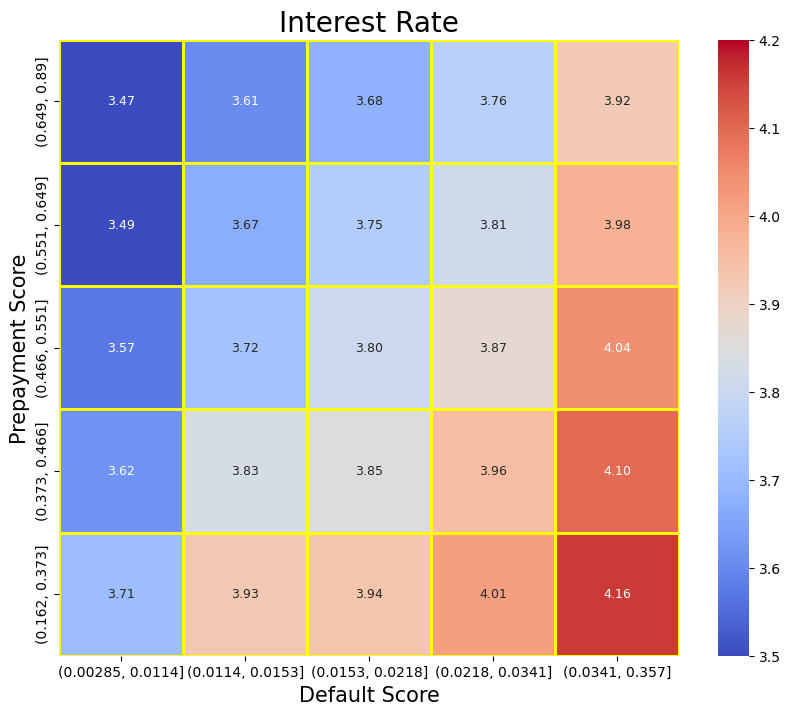

In [82]:
fig=plt.figure(figsize=(10, 8))
ax=plt.axes()
sns.heatmap(interest_rate, cmap='coolwarm', fmt=".2f", vmin=3.5, vmax=4.2, linewidths=2, linecolor='yellow',
            annot=True, annot_kws={"size": 9}).invert_yaxis()
ax.set_title("Interest Rate", fontsize=20)
ax.set_xlabel('Default Score', fontsize=15)
ax.set_ylabel('Prepayment Score', fontsize=15)

In [83]:
# let's check by loan term

# 30-year fixed
interest_rate=check_rate[check_rate['ORIG_TERM']==360].pivot_table(index='prepay_bin', columns='default_bin', 
                                                                   values='ORIG_RATE', aggfunc='mean', dropna=False)
interest_rate

default_bin     (0.00285, 0.0114]  (0.0114, 0.0153]  (0.0153, 0.0218]  \
prepay_bin                                                              
(0.162, 0.373]           3.965282          4.105838          4.069071   
(0.373, 0.466]           3.830490          3.945442          3.924180   
(0.466, 0.551]           3.764066          3.836080          3.887075   
(0.551, 0.649]           3.681572          3.776534          3.825267   
(0.649, 0.89]            3.640582          3.718380          3.744911   

default_bin     (0.0218, 0.0341]  (0.0341, 0.357]  
prepay_bin                                         
(0.162, 0.373]          4.092880         4.240944  
(0.373, 0.466]          3.989613         4.172298  
(0.466, 0.551]          3.923877         4.104462  
(0.551, 0.649]          3.853581         4.021436  
(0.649, 0.89]           3.797696         3.944716

Text(95.72222222222221, 0.5, 'Prepayment Score')

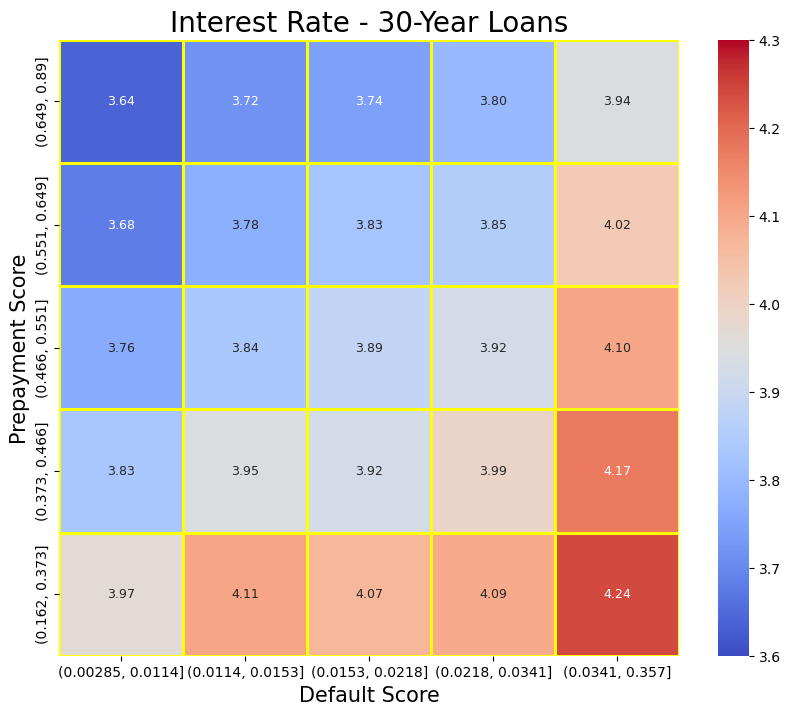

In [84]:
fig=plt.figure(figsize=(10, 8))
ax=plt.axes()
sns.heatmap(interest_rate, cmap='coolwarm', fmt=".2f", vmin=3.6, vmax=4.3, linewidths=2, linecolor='yellow',
            annot=True, annot_kws={"size": 9}).invert_yaxis()
ax.set_title("Interest Rate - 30-Year Loans", fontsize=20)
ax.set_xlabel('Default Score', fontsize=15)
ax.set_ylabel('Prepayment Score', fontsize=15)

In [85]:
# 15-year fixed
interest_rate=check_rate[check_rate['ORIG_TERM']==180].pivot_table(index='prepay_bin', columns='default_bin', 
                                                                   values='ORIG_RATE', aggfunc='mean', dropna=False)
interest_rate

default_bin     (0.00285, 0.0114]  (0.0114, 0.0153]  (0.0153, 0.0218]  \
prepay_bin                                                              
(0.162, 0.373]           3.403655          3.493141          3.505934   
(0.373, 0.466]           3.297730          3.391285          3.373789   
(0.466, 0.551]           3.215459          3.270486          3.287479   
(0.551, 0.649]           3.144226          3.230028          3.208644   
(0.649, 0.89]            3.121654          3.152705          3.191553   

default_bin     (0.0218, 0.0341]  (0.0341, 0.357]  
prepay_bin                                         
(0.162, 0.373]          3.588956         3.665397  
(0.373, 0.466]          3.483941         3.510798  
(0.466, 0.551]          3.371243         3.514190  
(0.551, 0.649]          3.244485         3.375954  
(0.649, 0.89]           3.187370         3.305553

Text(95.72222222222221, 0.5, 'Prepayment Score')

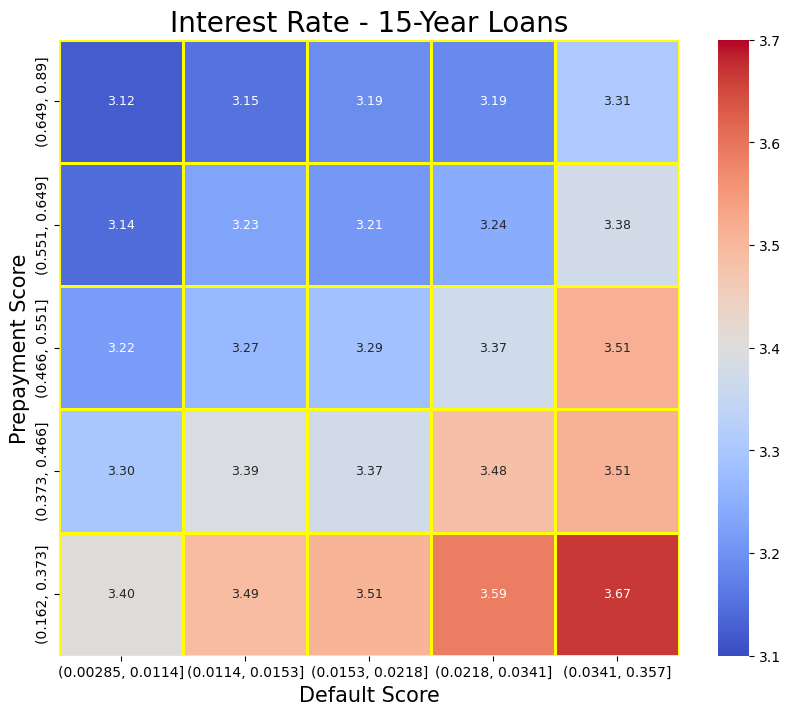

In [86]:
fig=plt.figure(figsize=(10, 8))
ax=plt.axes()
sns.heatmap(interest_rate, cmap='coolwarm', fmt=".2f", vmin=3.1, vmax=3.7, linewidths=2, linecolor='yellow',
            annot=True, annot_kws={"size": 9}).invert_yaxis()
ax.set_title("Interest Rate - 15-Year Loans", fontsize=20)
ax.set_xlabel('Default Score', fontsize=15)
ax.set_ylabel('Prepayment Score', fontsize=15)

## Summary


### Default Model ROC AUC
* Logistic Regression: 0.657
* Decision Tree: 0.654
* Naive Bayes: 0.649
* Stochastic Gradient Descent: 0.500
* K Nearest Neighborhood: 0.629
* Light Gradient Boosting: 0.667
* XGBoost: 0.654
* Random Forest: 0.630
* Ensemble Learning (Weighted Average): 0.630

### Prepayment Model ROC AUC
* Logistic Regression: 0.712
* Decision Tree: 0.698
* Naive Bayes: 0.679
* Stochastic Gradient Descent: 0.505
* K Nearest Neighborhood: 0.653
* Light Gradient Boosting: 0.734
* XGBoost: 0.723
* Random Forest: 0.704
* Ensemble Learning (Weighted Average): 0.710

## Conclusion

The Light Gradient Boosting model achieved the highest ROC AUC for both the Default Model (0.667) and the Prepayment Model (0.734), indicating strong predictive performance for identifying both default and prepayment risks. In general, ensemble and boosting methods performed better than simpler models, likely due to their ability to capture complex relationships in the data.

The results suggest that for both default and prepayment analysis, leveraging boosting algorithms like Light Gradient Boosting or XGBoost provides a more accurate classification compared to traditional methods like logistic regression or decision trees.